#  Series temporales. Modelos de Suavizado exponencial y ARIMA

# Series temporales I. 
## Suavizado

Esquema de trabajo: 

1. Leer valores de la serie y convertir a formato legible por python
2. Representar la serie para intuir componentes presentes
3. Descomposición de la serie y contraste de estacionariedad
4. Creación de partición en ventanas training/test
5. Aplicación de modelos de suavizado y evaluación de ajuste
6. Aplicación de modelos Arima y evaluación de ajuste

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
Air = pd.read_csv(r'C:\Users\Usuario\Documents\CIENCIA DE DATOS\REPOSITORIO GITHUB\MINERÍA DE DATOS Y MODELACIÓN ejercicios\3. Ejercicio base datos pasajeros\script_base_pasajeros_suav_arima\AirPassengers.csv')
Air.head()

Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121

In [5]:
Air.describe()

Passengers
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000

In [7]:
Air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [9]:
# Convertir en serie temporal
Air.set_index(['Month'],inplace=True)
Air.index=pd.to_datetime(Air.index)

In [11]:
Air

Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432

[144 rows x 1 columns]

In [13]:
Air.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


## Estudio descriptivo 

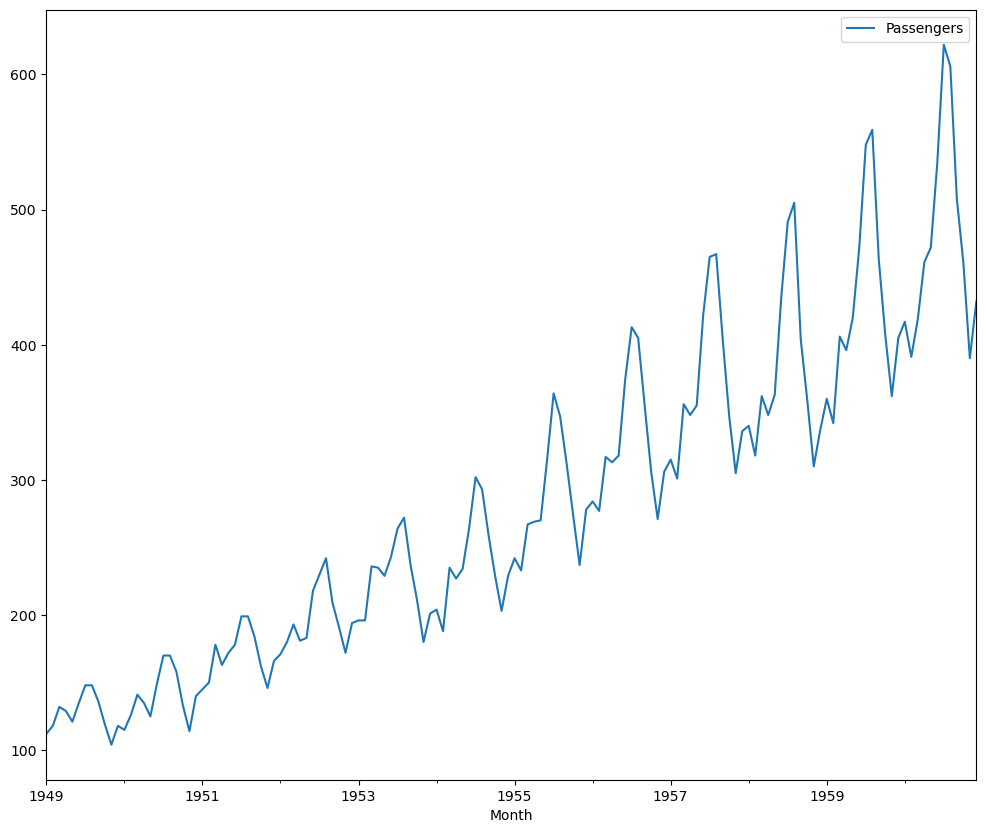

In [15]:
# Opción gráfica para que los plot() salgan grandes
plt.rcParams["figure.figsize"] = (12,10)
Air.plot()
plt.show()

Definir función que calcule el test de **Dickey Fuller** para la estacionariedad de la serie. De esta forma, en cualquier momento, introduciendo el vector de valores de la serie, se obtiene el contraste de hipótesis

H0: La serie NO es estacionaria

H1: La serie es estacionaria

Interesa que el contraste de hipótesis sea rechazado (p-valor < 0.05)

In [17]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', regression ='ct')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [19]:
# Se prueba con la serie al natural
test_stationarity(Air)

Results of Dickey-Fuller Test:
Test Statistic                  -2.100782
p-value                          0.545659
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -4.030152
Critical Value (5%)             -3.444818
Critical Value (10%)            -3.147182
dtype: float64


### Descomposición de la serie

Con base en la descomposición descriptiva por medias móviles, se extraen las componentes de tendencia y estacionalidad

**Descomposición aditiva**

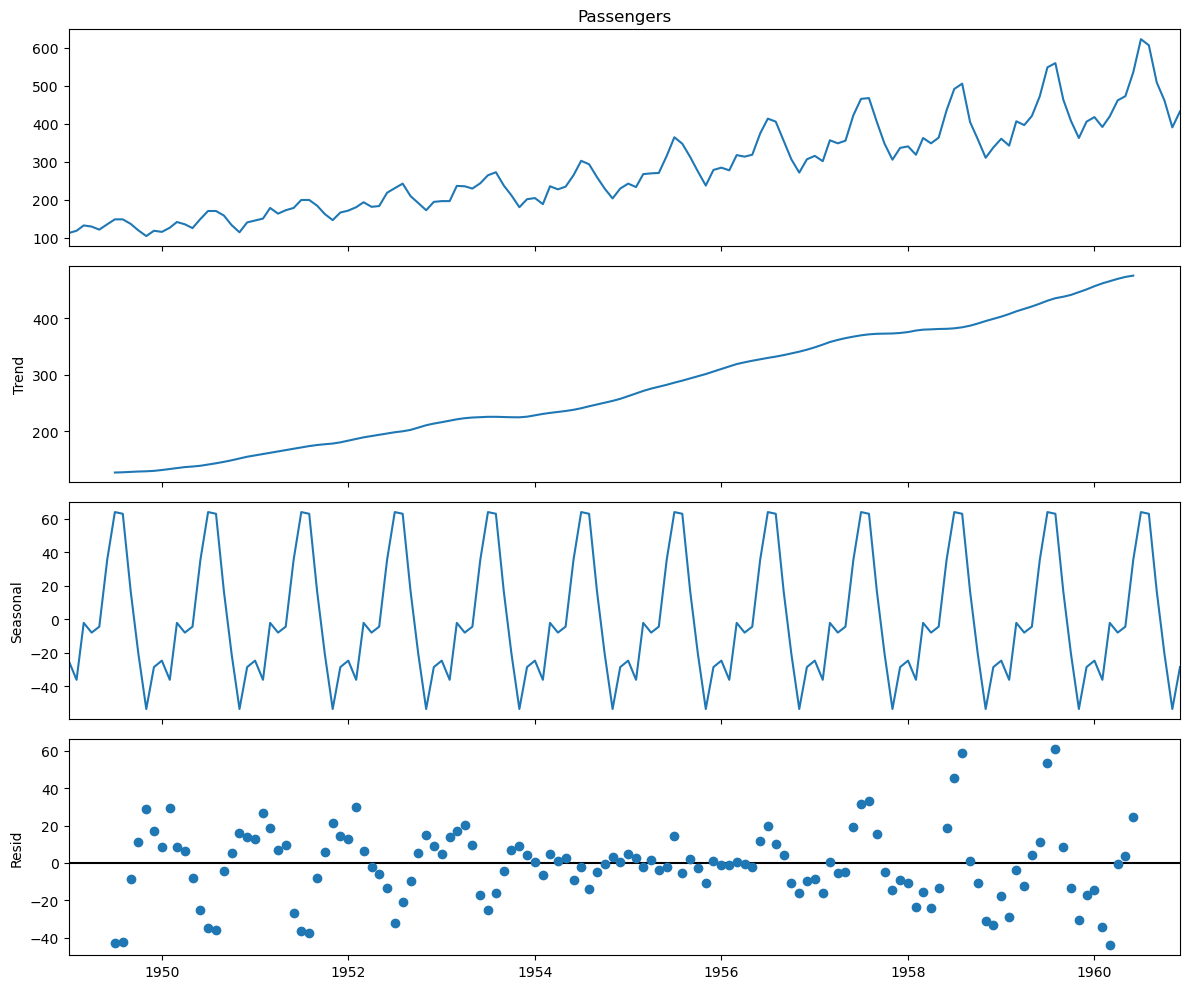

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Aplicar descomposición aditiva
Air_desc_Ad = seasonal_decompose(Air['Passengers'], model='additive',period=12)
Air_desc_Ad.plot()
plt.show()

In [23]:
# Evaluar estacionariedad de los residuos de la descomposición aditiva. 
# Debido a que la tendencia se calcula por medias móviles, los primeros y últimos valores de la serie son NA
test_stationarity(Air_desc_Ad.resid.dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -5.279797
p-value                          0.000062
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -4.037614
Critical Value (5%)             -3.448373
Critical Value (10%)            -3.149257
dtype: float64


**Descomposición multiplicativa** 



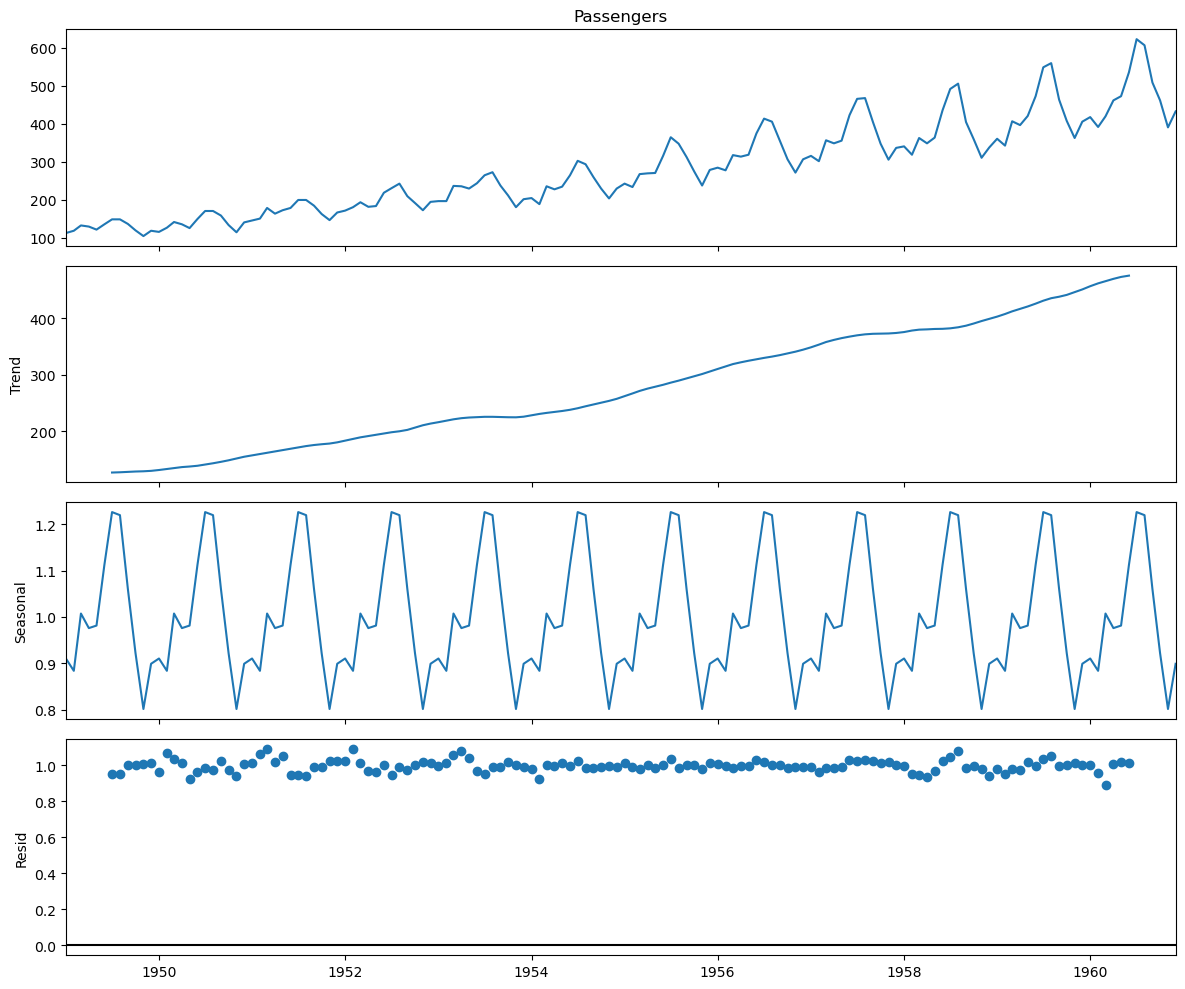

In [25]:
# Aplicar descomposición aditiva
Air_desc_Mul = seasonal_decompose(Air['Passengers'], model='multiplicative',period=12)
Air_desc_Mul.plot()
plt.show()

In [27]:
# Evaluar estacionariedad de los residuos de la descomposición Multiplicativa
test_stationarity(Air_desc_Mul.resid.dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -6.057240
p-value                          0.000002
#Lags Used                       9.000000
Number of Observations Used    122.000000
Critical Value (1%)             -4.034960
Critical Value (5%)             -3.447109
Critical Value (10%)            -3.148519
dtype: float64


In [29]:
# Crea un gráfico estacional de una columna del marco de datos de entrada. Considera las primeras columnas de manera predeterminada
def seasonal_plot(df, season='year', index='month', column=None):
    
    if column == None:
        column = df.columns[0]
        
    piv_index = getattr(df.index, index)
    piv_season = getattr(df.index, season)
    
    piv = pd.pivot_table(df, index=piv_index, columns=piv_season, values=[column])
    piv.plot(figsize=(12,8))

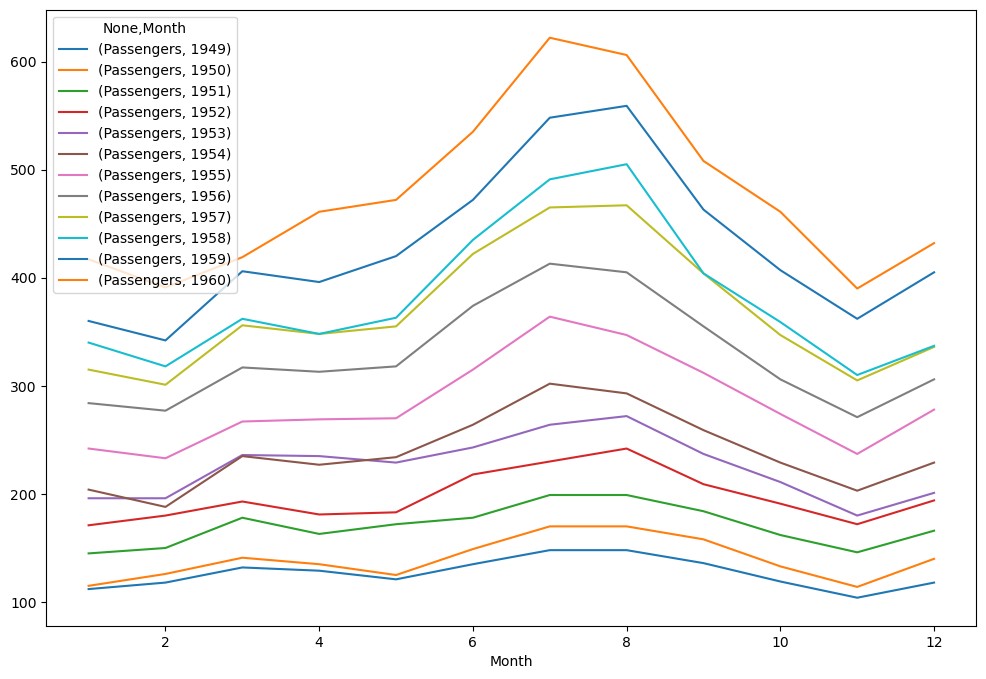

In [31]:
# Gráfico de evolución de pasajeros por mes
seasonal_plot(Air)
plt.show()

### Hacia la estacionariedad

Extraer las componentes identificadas para generar una serie residual y comprobar si es estacionaria una vez eliminados los efectos típicos de las series temporales 

El esquema es: 

1. Estabilización de la varianza. Transformación Logaritmica
2. Diferenciación regular
3. Diferenciación estacional

Con la serie resultante, se comprueba la estacionariedad y será con la que podemos valorar autocorrelaciones simples y parciales para proponer órdenes ARIMA tentativos

#### Estabilización de la varianza. Transformación Logaritmica

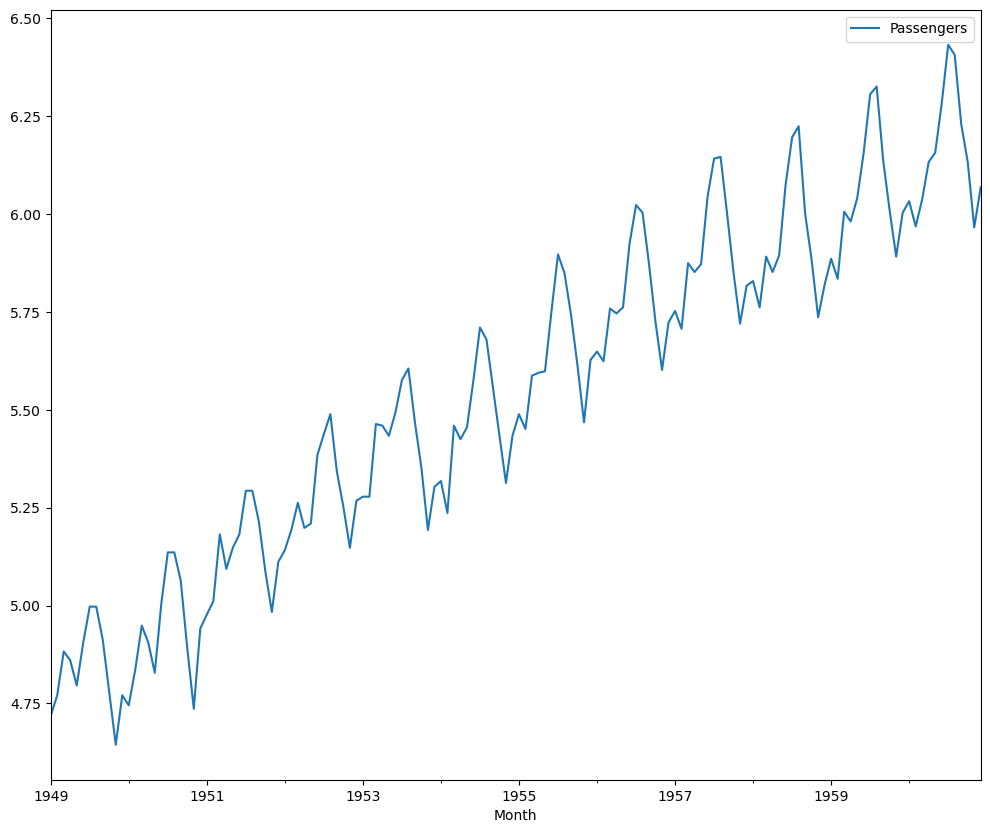

In [33]:
AirLog = np.log(Air)
AirLog.plot()
plt.show()

#### Diferenciación regular



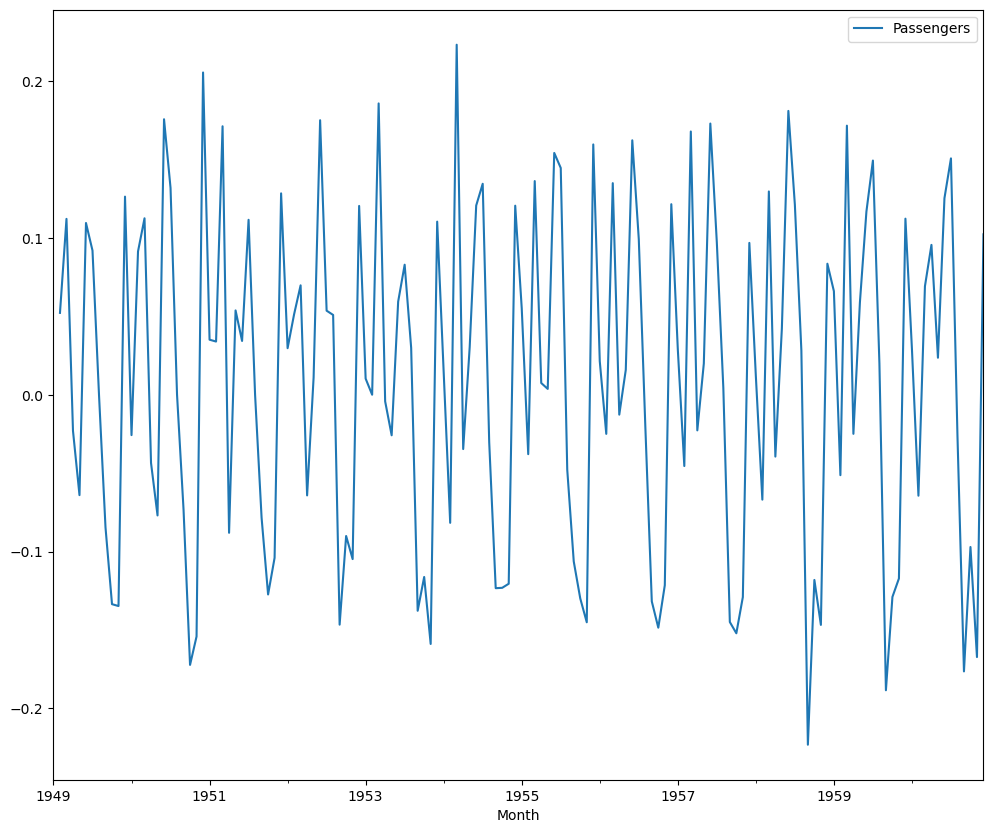

In [35]:
AirLog_diff_1 = AirLog.diff(periods=1)
AirLog_diff_1.plot()
plt.show()

#### Diferenciación estacional



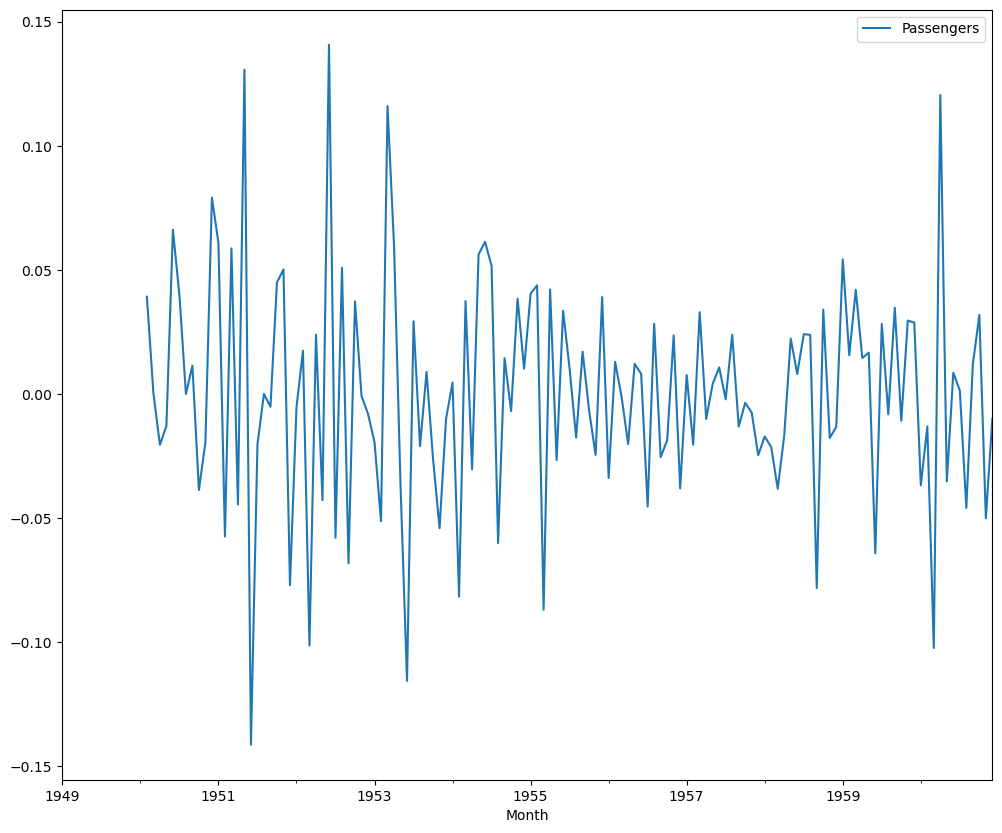

In [37]:
AirLog_diff_1_12 = AirLog_diff_1.diff(periods=12)
AirLog_diff_1_12.plot()
plt.show()

#### Comprobación de estacionariedad



In [39]:
test_stationarity(AirLog_diff_1_12.dropna(inplace=False))

Results of Dickey-Fuller Test:
Test Statistic                  -4.413001
p-value                          0.002087
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -4.037614
Critical Value (5%)             -3.448373
Critical Value (10%)            -3.149257
dtype: float64


#### Autocorrelaciones 



In [41]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

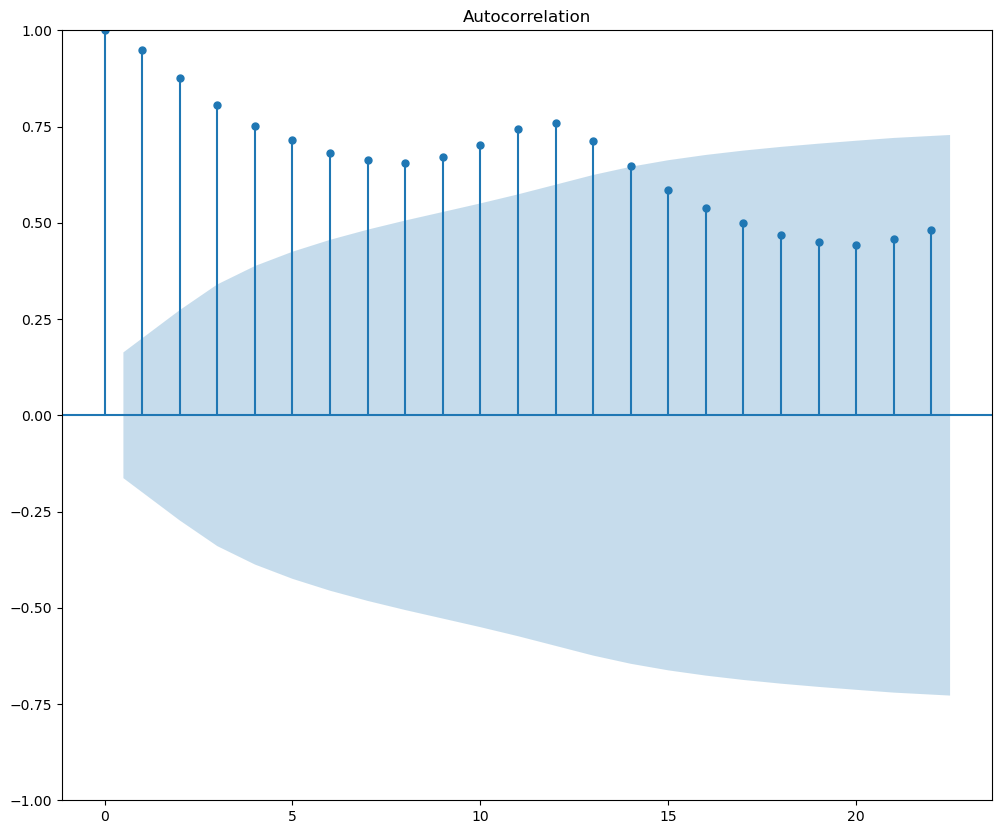

In [43]:
plot_acf(Air.dropna(inplace=False))
plt.show()

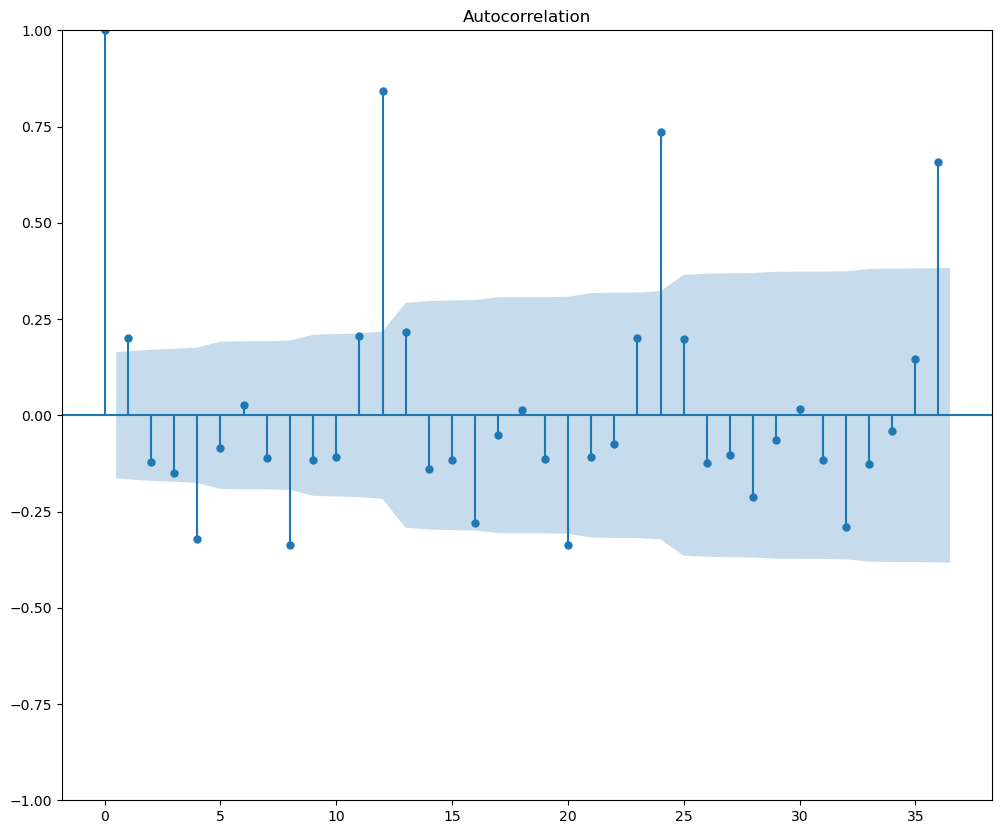

In [45]:
plot_acf(AirLog_diff_1.dropna(inplace=False),lags=36)
plt.show()

In [47]:
AirLog_diff_1_12

Passengers
Month                 
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
...                ...
1960-08-01   -0.045934
1960-09-01    0.012024
1960-10-01    0.031830
1960-11-01   -0.050082
1960-12-01   -0.009964

[144 rows x 1 columns]

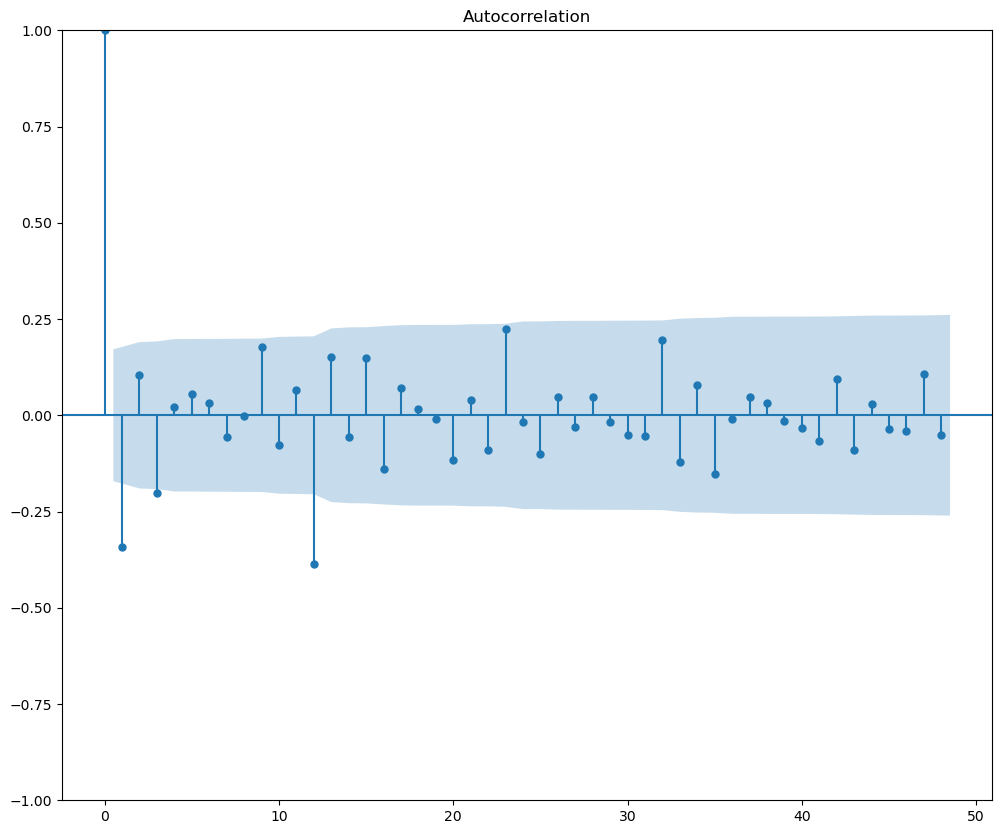

In [49]:
plot_acf(AirLog_diff_1_12.dropna(inplace=False), lags=48)
plt.show()

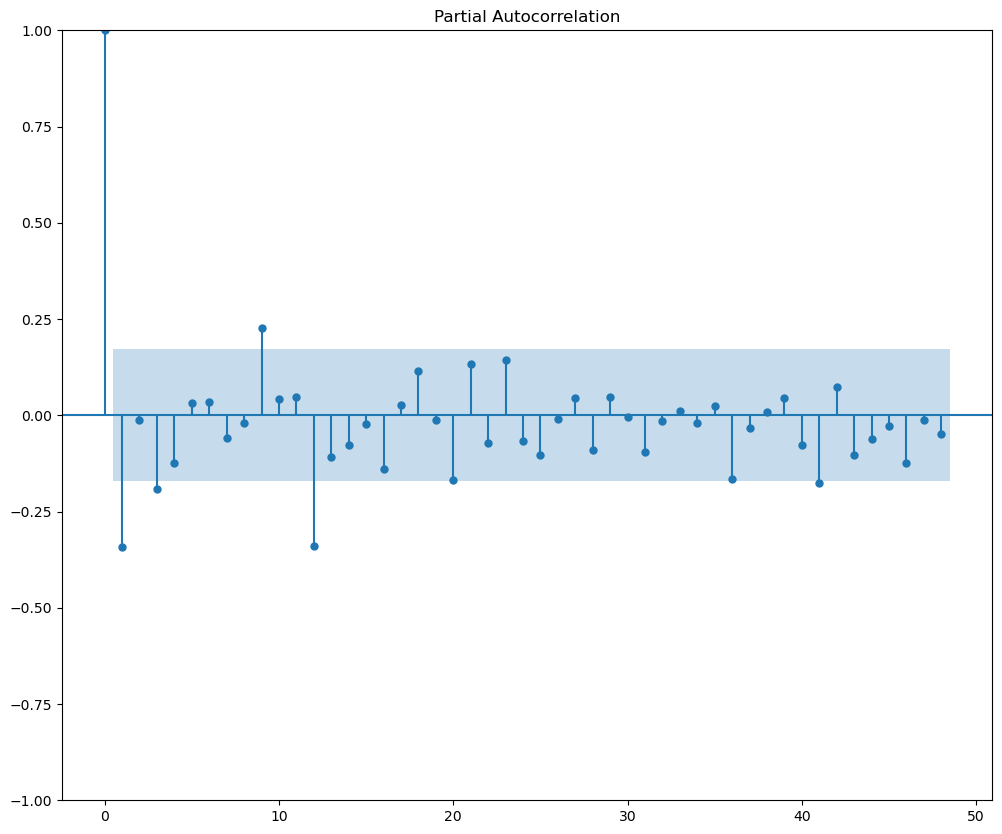

In [51]:
plot_pacf(AirLog_diff_1_12.dropna(inplace=False), lags=48,method='ywm')
plt.show()

In [53]:
# Tets Ljung-box
sm.stats.acorr_ljungbox(AirLog_diff_1_12.dropna(inplace=False), lags=12, return_df=True)

lb_stat     lb_pvalue
1   15.595655  7.843461e-05
2   17.086040  1.949008e-04
3   22.647794  4.781777e-05
4   22.710382  1.446614e-04
5   23.138684  3.175679e-04
6   23.270941  7.106307e-04
7   23.704967  1.283650e-03
8   23.705049  2.567712e-03
9   28.147330  9.012662e-04
10  28.986885  1.252151e-03
11  29.588746  1.837982e-03
12  51.472840  7.685466e-07

In [55]:
sm.stats.acorr_ljungbox(Air, lags=12, return_df=True)

lb_stat      lb_pvalue
1    132.141539   1.393231e-30
2    245.646160   4.556318e-54
3    342.674826   5.751088e-74
4    427.738684   2.817731e-91
5    504.796570  7.360195e-107
6    575.601854  4.264008e-121
7    643.038593  1.305463e-134
8    709.484498  6.496271e-148
9    779.591231  5.249370e-162
10   857.068639  1.100789e-177
11   944.390318  1.766396e-195
12  1036.481907  2.682212e-214

## Modelos de suavizado

In [57]:
import statsmodels.tsa.holtwinters as ets
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# Generar la serie logaritmica
AirLog = Air.copy()
AirLog['Passengers'] = np.log(AirLog['Passengers'])
AirLog

Air_tr = AirLog[:'1958-12-01']
Air_tst = AirLog['1959-01-01':]
Air_tst

Passengers
Month                 
1959-01-01    5.886104
1959-02-01    5.834811
1959-03-01    6.006353
1959-04-01    5.981414
1959-05-01    6.040255
1959-06-01    6.156979
1959-07-01    6.306275
1959-08-01    6.326149
1959-09-01    6.137727
1959-10-01    6.008813
1959-11-01    5.891644
1959-12-01    6.003887
1960-01-01    6.033086
1960-02-01    5.968708
1960-03-01    6.037871
1960-04-01    6.133398
1960-05-01    6.156979
1960-06-01    6.282267
1960-07-01    6.432940
1960-08-01    6.406880
1960-09-01    6.230481
1960-10-01    6.133398
1960-11-01    5.966147
1960-12-01    6.068426

Definir una función para evaluar un modelo (será válido para modelos de suavizado y arima de statsmodels pero no para auto_arima

In [59]:
# forecast_accuracy(fc, test.values)

# Función para evaluar modelo
def eval_model(model,tr,tst,name='Model',lags=12,serie='serie'):
    lb = np.mean(sm.stats.acorr_ljungbox(model.resid, lags=lags, return_df=True).lb_pvalue)
    pred = model.forecast(steps=len(tst))
    fig1, ax = plt.subplots()
    ax.plot(tr, label='training')
    ax.plot(tst, label='test')
    ax.plot(pred, label='prediction')
    plt.legend(loc='upper left')
    tit = name + ":  LjungBox p-value --> " + str(lb) + "\n MAPE: " + str(round(mean_absolute_percentage_error(tst, pred)*100,2)) + "%"
    plt.title(tit)
    plt.ylabel(serie)
    plt.xlabel('Date')
    plt.show()
    print(lb)

#### Suavizado Simple

Se sabe que no va a ajustar bien pues es para series sin tendencia y estacionalidad. Solo por ver cómo ajustarlo en caso de necesidad

In [61]:
ses = ets.SimpleExpSmoothing(Air_tr).fit()
ses.summary()

C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                       SimpleExpSmoothing Model Results                       
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  120
Model:             SimpleExpSmoothing   SSE                              1.332
Optimized:                       True   AIC                           -536.073
Trend:                           None   BIC                           -530.498
Seasonal:                        None   AICC                          -535.725
Seasonal Periods:                None   Date:                 Mon, 21 Apr 2025
Box-Cox:                        False   Time:                         19:49:21
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
initial_level              4.7184989                  l.0                False
------------------------------------------------------------------------------
"""

Evaluación del modelo SES.



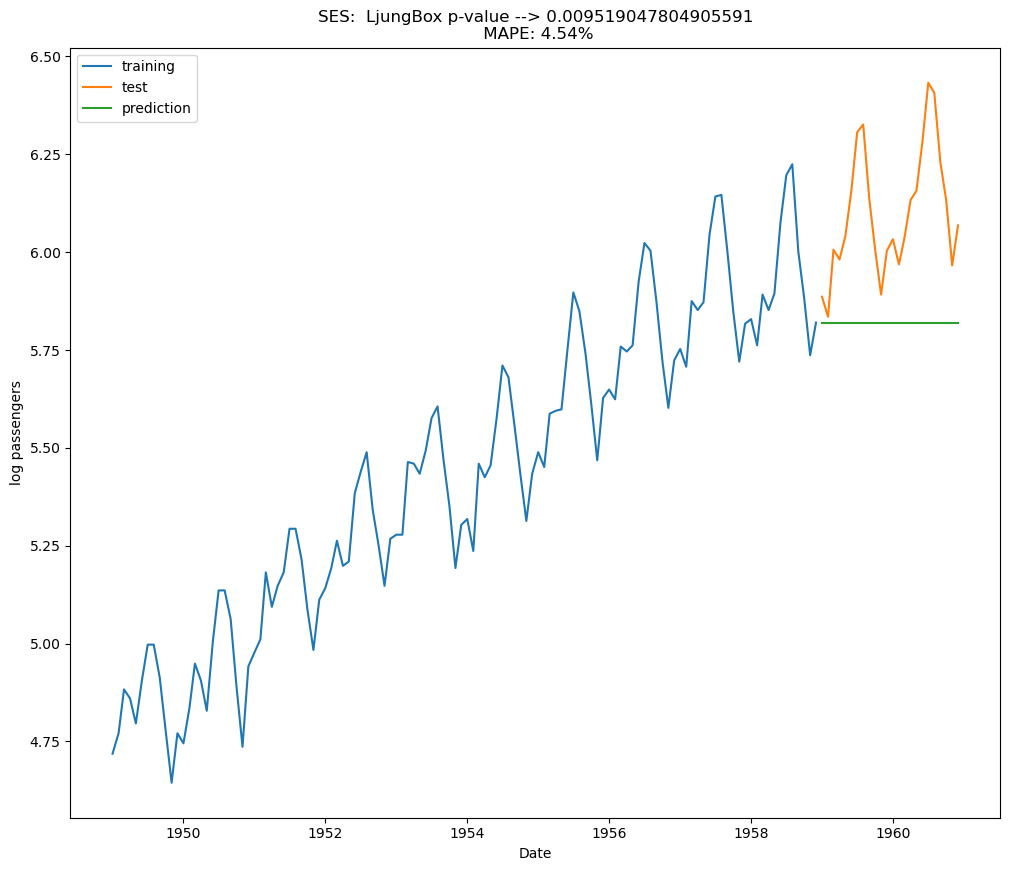

0.009519047804905591


In [63]:
# Evaluar SES
eval_model(ses,Air_tr,Air_tst,'SES',serie='log passengers')

#### Suavizado doble de Holt

Con pendiente pero sin componente estacional. Se espera una recta con pendiente como predicción

C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                              Holt Model Results                              
Dep. Variable:             Passengers   No. Observations:                  120
Model:                           Holt   SSE                              1.386
Optimized:                       True   AIC                           -527.298
Trend:                       Additive   BIC                           -516.148
Seasonal:                        None   AICC                          -526.555
Seasonal Periods:                None   Date:                 Mon, 21 Apr 2025
Box-Cox:                        False   Time:                         19:50:27
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
smoothing_trend            0.0272976                

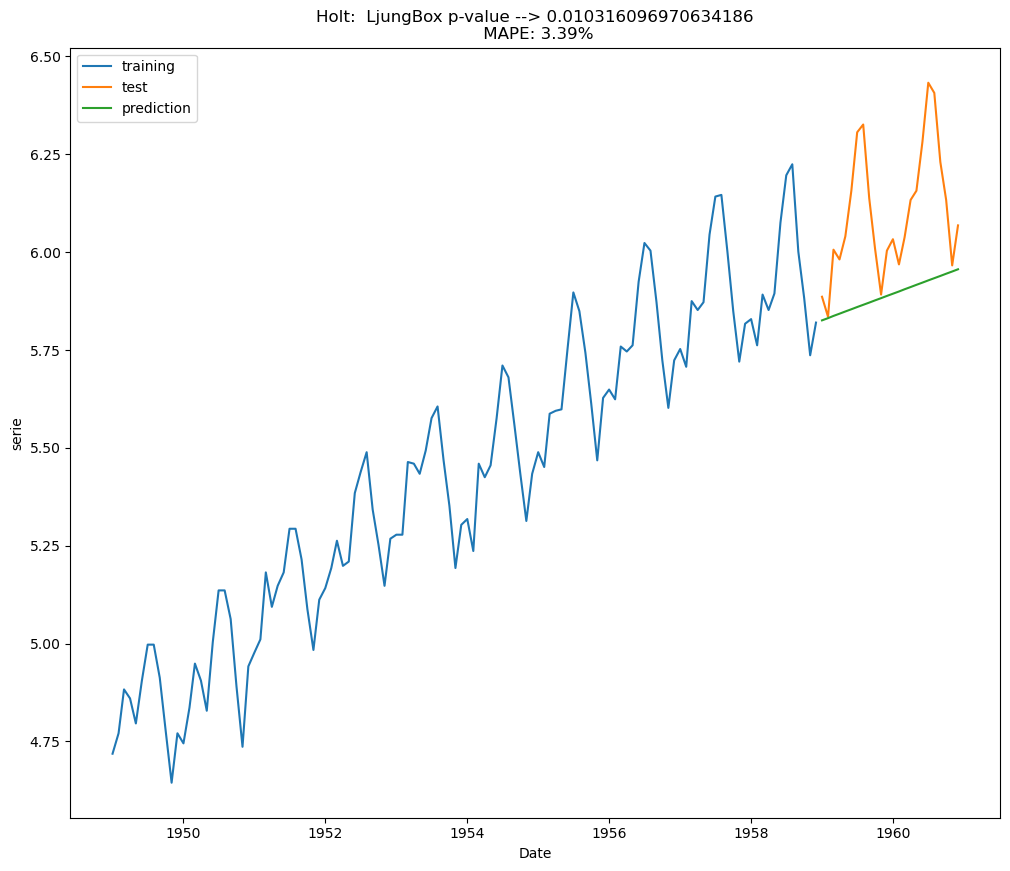

0.010316096970634186


In [65]:
# Suavizado de Holt
holt = ets.Holt(Air_tr).fit()
print(holt.summary())

eval_model(holt,Air_tr,Air_tst,'Holt')

#### Suavizado de Holt Winters Aditivo

Con el aspecto de la serie y la clara heterocedasticidad, no parece que sea la mejor opción, pero probar con el logaritmo para ver el cambio

C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                  120
Model:             ExponentialSmoothing   SSE                              0.151
Optimized:                         True   AIC                           -769.603
Trend:                         Additive   BIC                           -725.004
Seasonal:                      Additive   AICC                          -762.831
Seasonal Periods:                    12   Date:                 Mon, 21 Apr 2025
Box-Cox:                          False   Time:                         19:50:38
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000                alpha                 True
smoothing_trend          

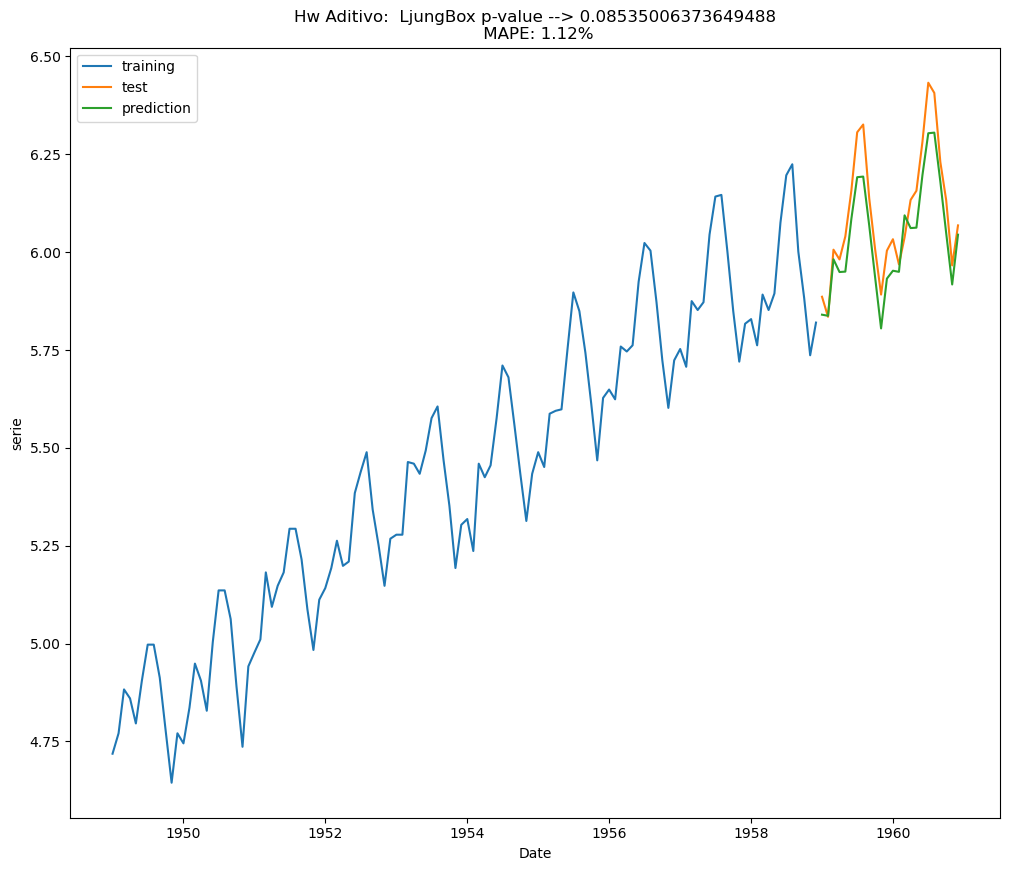

0.08535006373649488


In [67]:
hw_add = ets.ExponentialSmoothing(Air_tr,trend='add', damped_trend=False, seasonal='add').fit()
print(hw_add.summary())

eval_model(hw_add,Air_tr,Air_tst,'Hw Aditivo')

#### Suavizado de Holt Winters Multiplicativo

Para captar la componente estacional no constante con el tiempo

C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


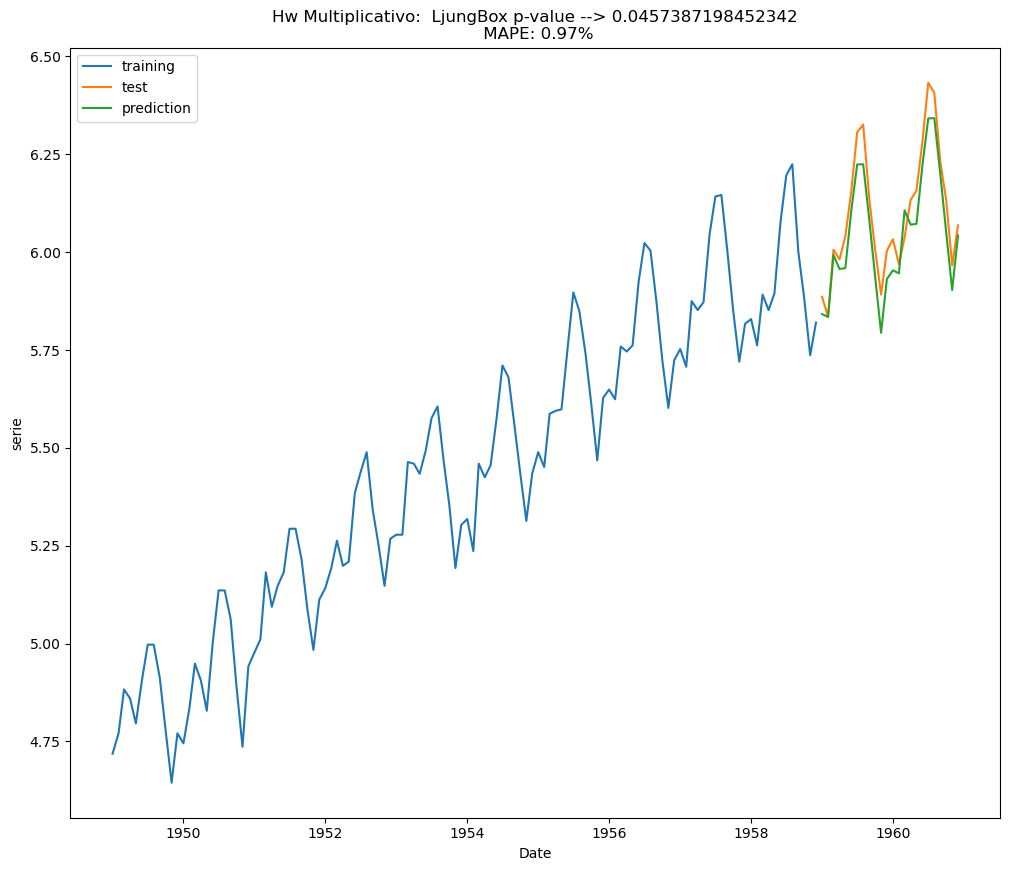

0.0457387198452342


In [69]:
hw_mul = ets.ExponentialSmoothing(Air_tr,trend='add', damped_trend=False, seasonal='mul').fit()
hw_mul.summary()

eval_model(hw_mul,Air_tr,Air_tst,'Hw Multiplicativo')

#### Autocorrelaciones con intervalos de confianza

Evaluar los correlogramas de los residuos para este último modelo multiplicativo

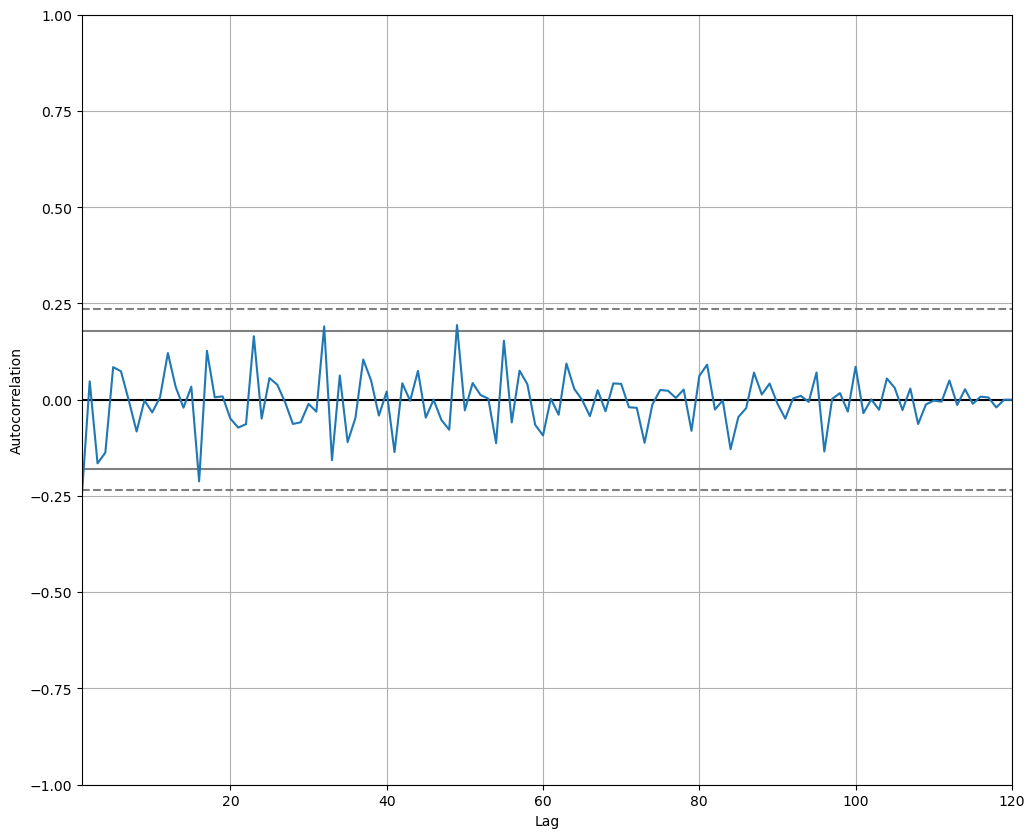

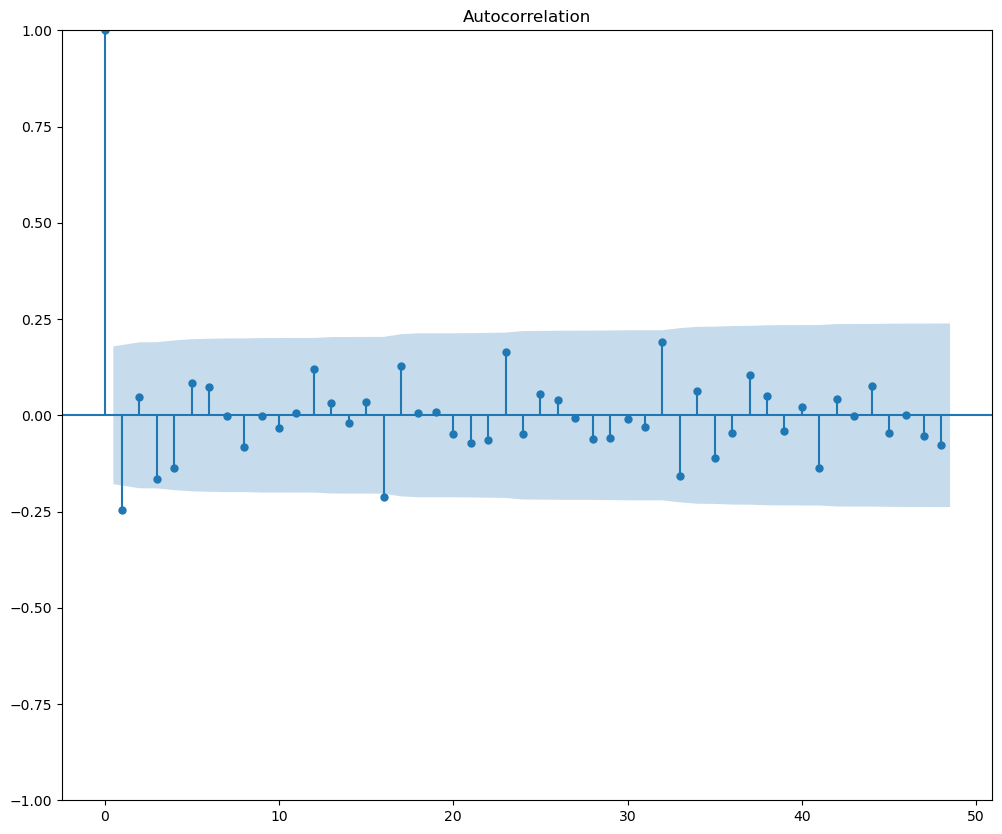

In [71]:
from pandas.plotting import autocorrelation_plot

plt.clf()
autocorrelation_plot(hw_mul.resid)
plt.show()

plot_acf(hw_mul.resid, lags=48)
plt.show()

Y el aditivo?



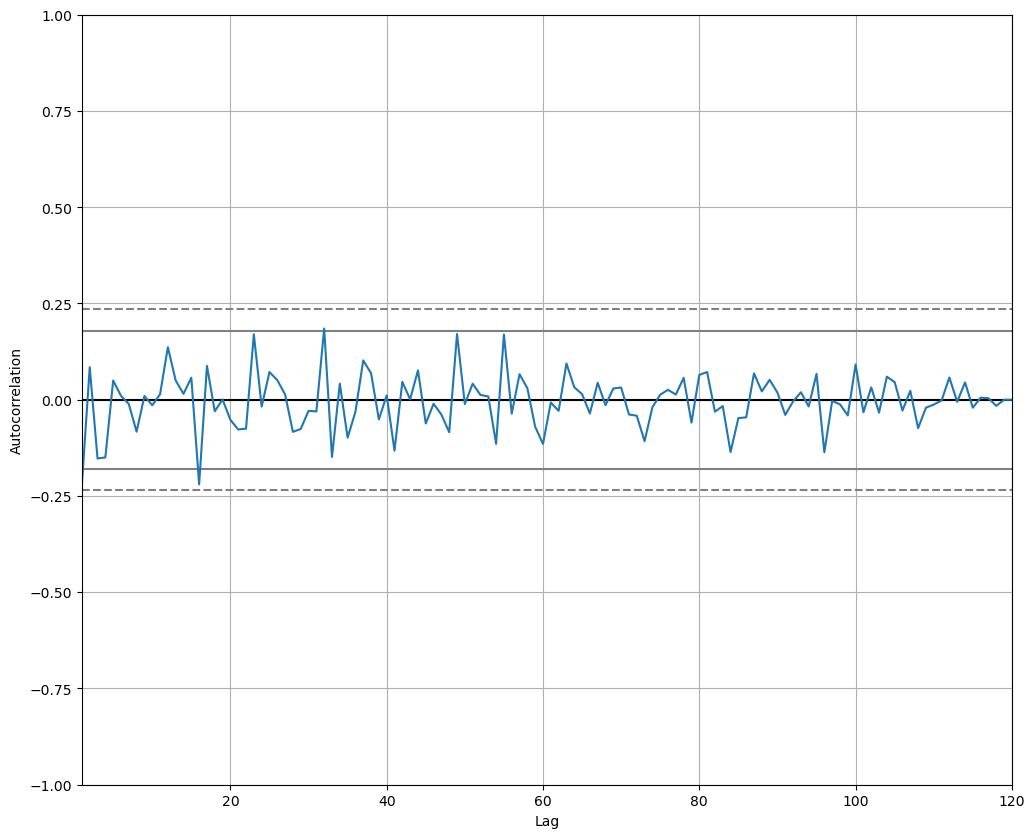

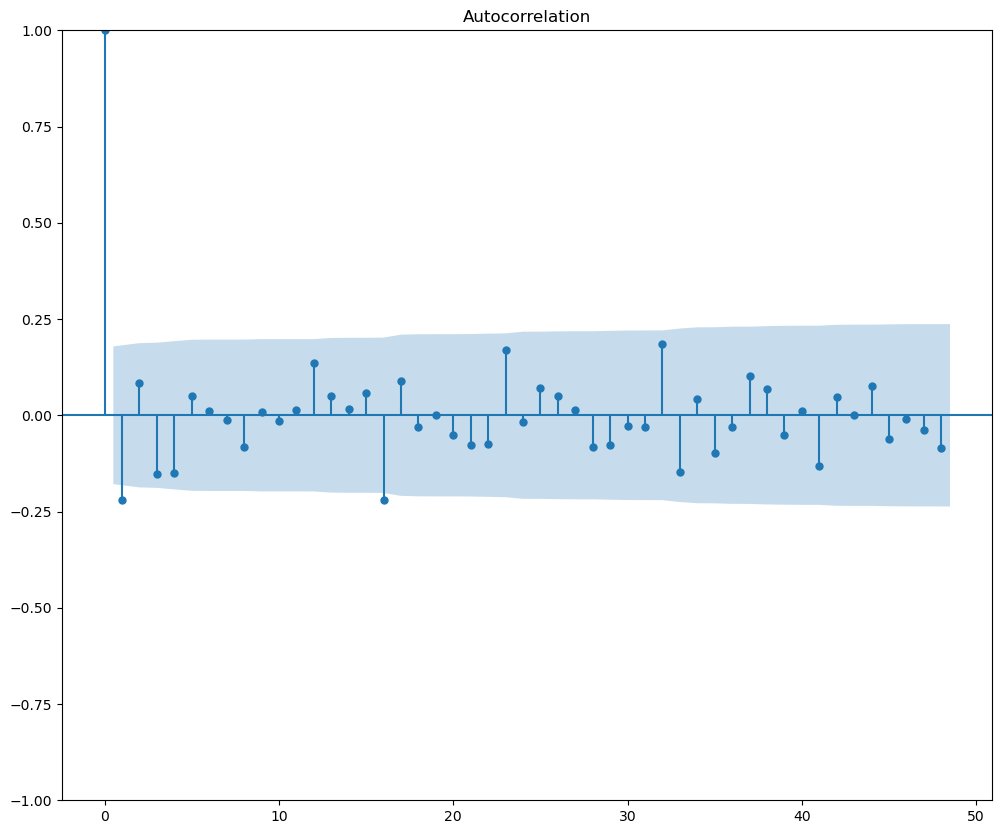

In [73]:
plt.clf()
autocorrelation_plot(hw_add.resid)
plt.show()

plot_acf(hw_add.resid, lags=48)
plt.show()

# Series temporales II. Modelos ARIMA


## Definición de funciones para evaluación

In [75]:
import scipy.stats as stats
import seaborn as sns

# Función para evaluar residuos a través de contrastes de hipótesis
def residcheck(residuals, lags):
    """ Función para verificar si los residuos son ruido blanco. Lo ideal es que los residuos no estén correlacionados, tengan una media cero, una varianza constante y 
    una distribución normal. Los dos primeros son obligatorios, mientras que los dos últimos son buenos. Si no se cumplen los dos primeros, no se ha capturado completamente 
    la información de los datos para la predicción.
    Considere un modelo diferente y/o agregue una variable exógena.
    Si la prueba Ljung Box muestra p > 0,05, los residuos como grupo son ruido blanco. Algunos rezagos aún podrían ser significativos.  
    Los rezagos deben ser min(2*seasonal_period, T/5)"""
    
    resid_mean = np.mean(residuals)
    lj_p_val = np.mean(sm.stats.acorr_ljungbox(x=residuals, lags=lags).lb_pvalue)
    norm_p_val =  stats.jarque_bera(residuals)[1]
    adfuller_p = adfuller(residuals)[1]
        
      
    fig = plt.figure(figsize=(10,8))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2);
    acf_ax = plt.subplot2grid(layout, (1, 0));
    kde_ax = plt.subplot2grid(layout, (1, 1));
    
    residuals.plot(ax=ts_ax)
    plot_acf(residuals, lags=lags, ax=acf_ax);
    sns.kdeplot(residuals);
    #[ax.set_xlim(1.5) for ax in [acf_ax, kde_ax]]
    sns.despine()
    plt.tight_layout();
    plt.show()
    print("** Mean of the residuals: ", np.around(resid_mean,2))
        
    print("\n** Ljung Box Test, p-value:", np.around(lj_p_val,3), 
        "(>0.05, Uncorrelated)" if (lj_p_val > 0.05) else "(<0.05, Correlated)")
        
    print("\n** Jarque Bera Normality Test, p_value:", np.around(norm_p_val,3),
        "(>0.05, Normal)" if (norm_p_val>0.05) else "(<0.05, Not-normal)")
        
    print("\n** AD Fuller, p_value:", np.around(adfuller_p,3), 
        "(>0.05, Non-stationary)" if (adfuller_p > 0.05) else "(<0.05, Stationary)")
    
    return ts_ax, acf_ax, kde_ax

In [77]:
# Función para evaluar modelo auto_arima
def eval_model_Aarima(model,tr,tst,name='Model',lags=12):
      lb = np.mean(sm.stats.acorr_ljungbox(model.resid(), lags=lags, return_df=True).lb_pvalue)
      pred = model.predict(n_periods=len(tst))
      fig1, ax = plt.subplots()
      ax.plot(tr, label='training')
      ax.plot(tst, label='test')
      ax.plot(pred, label='prediction')
      plt.legend(loc='upper left')
      tit = name + ":  LjungBox p-value --> " + str(lb) + "\n MAPE: " + str(round(mean_absolute_percentage_error(tst, pred)*100,2)) + "%"
      plt.title(tit)
      plt.ylabel('Serie')
      plt.xlabel('Date')
      plt.show()
      model.plot_diagnostics(figsize=(14,10))
      plt.show()

## Arima Manual

Ajustar modelos ARIMA manuales con SARIMAX de statsmodels. Se deben evaluar autodcoleraciones para identificar patrones de efectos AR y MA tentativos. Una vez se tiene una idea de los órdenes a proponer, se ajustan los modelos. Recordar correlogramas de la serie logaritmica y doblemente diferenciada

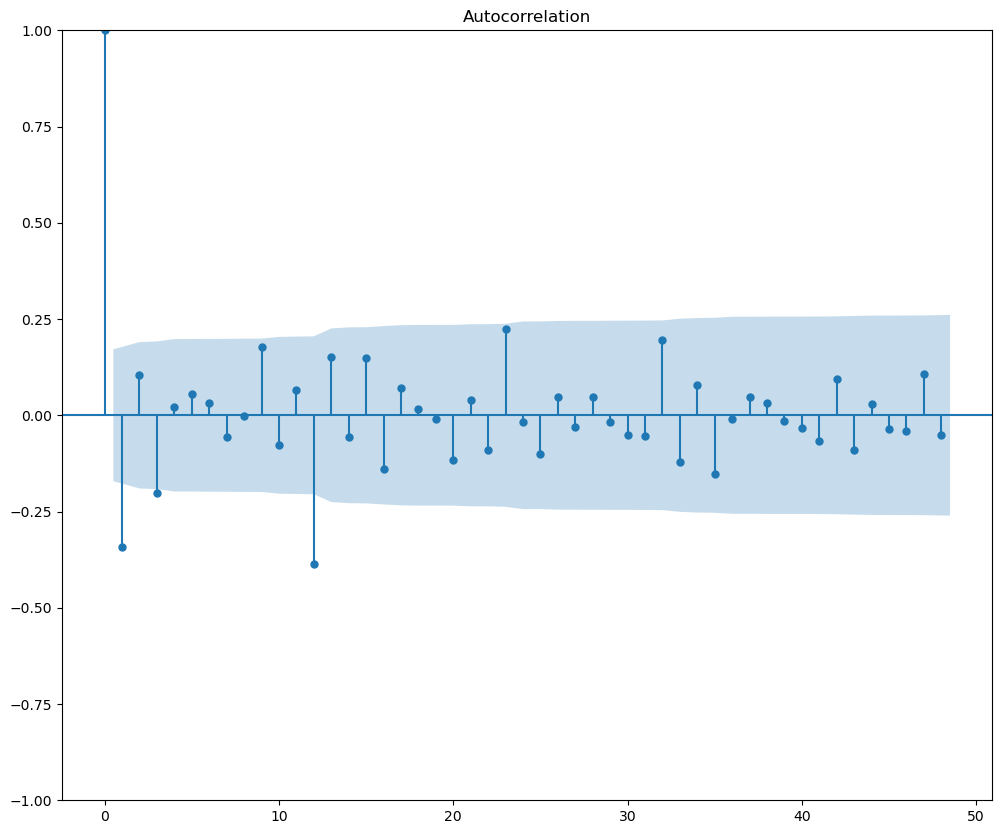

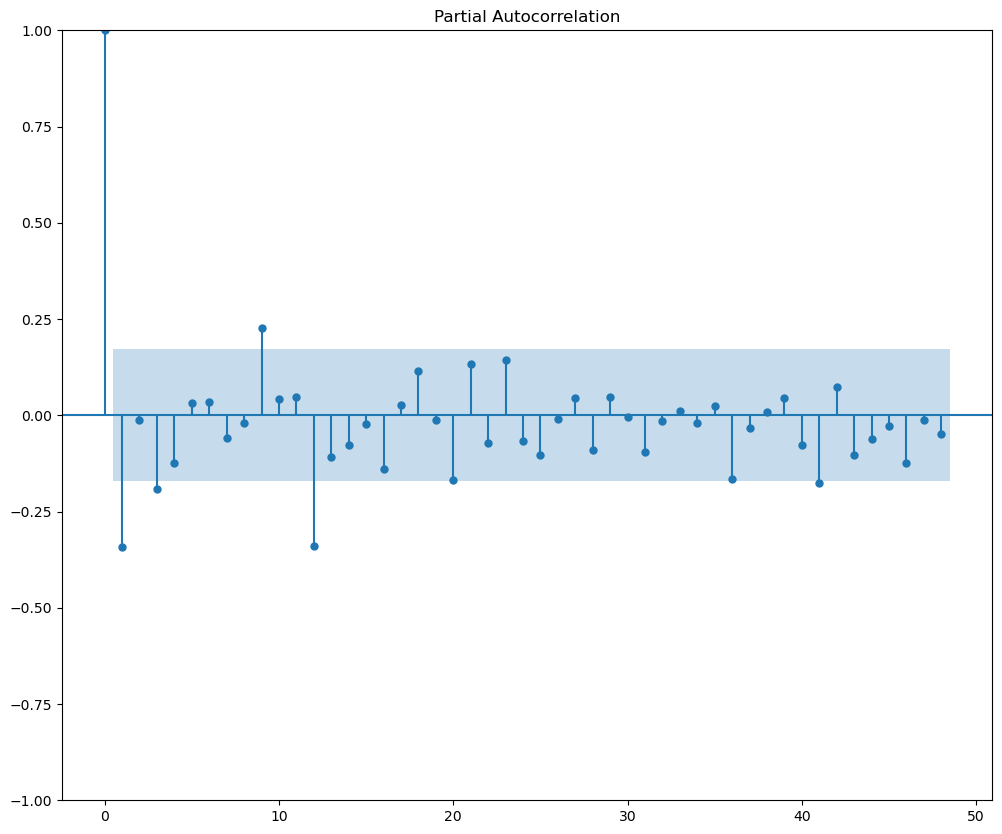

In [79]:
plot_acf(AirLog_diff_1_12.dropna(inplace=False),lags=48)
plt.show()
plot_pacf(AirLog_diff_1_12.dropna(inplace=False),lags=48,method='ywm')
plt.show()

**ACF**: En lo regular, seguro que algo hay. Podría ser un AR si se considera que hay decrecimiento rápido y no corte en el segundo retardo. Si es así, el órden del AR sería 1 por el corte en el pacf. En lo estacional, el retardo 12 es significativo así que algo debe haber. No queda muy claro en si parte AR o MA. 

**PACF**: Parece que hay un corte en el retardo 2, con lo que se piensa en AR, pero luego está ese retardo 3 con descenso. Es un MA o un enmascaramiento de ambos. En lo estacional, de nuevo el retardo 12 jugando y no queda clara la dinámica de desaparición de las autocorrelaciones estacionales.

Con esto se prueba algo así como ARIMA(0-1,1,0-1)(0-1,1,0-1)[12]

**Modelo 1** -> Con ambas partes MA

In [81]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
arima1 = SARIMAX(Air_tr, 
                order = (0, 1, 3), 
                seasonal_order =(0, 1, 3, 12))
  
arima_1 = arima1.fit()
arima_1.summary()

C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  120
Model:             SARIMAX(0, 1, 3)x(0, 1, 3, 12)   Log Likelihood                 199.500
Date:                            Mon, 21 Apr 2025   AIC                           -385.000
Time:                                    19:52:03   BIC                           -366.290
Sample:                                01-01-1949   HQIC                          -377.415
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3486      0.101     -3.443      0.001      -0.547      -0.150
ma.L2          0.0843      0.112      0.755      0.450      -0.134       0.303
ma.L3         -0.2033      0.133     -1.530      0.126      -0.464       0.057
ma.S.L12      -0.5787      0.127     -4.554      0.000      -0.828      -0.330
ma.S.L24       0.0003      0.142      0.002      0.998      -0.279       0.279
ma.S.L36       0.0383      0.143      0.268      0.789      -0.242       0.319
sigma2         0.0013      0.000      7.153      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.49
Prob(Q):                              0.91   Prob(JB):                         0.47
Heteroskedasticity (H):               0.39   Skew:                             0.02
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

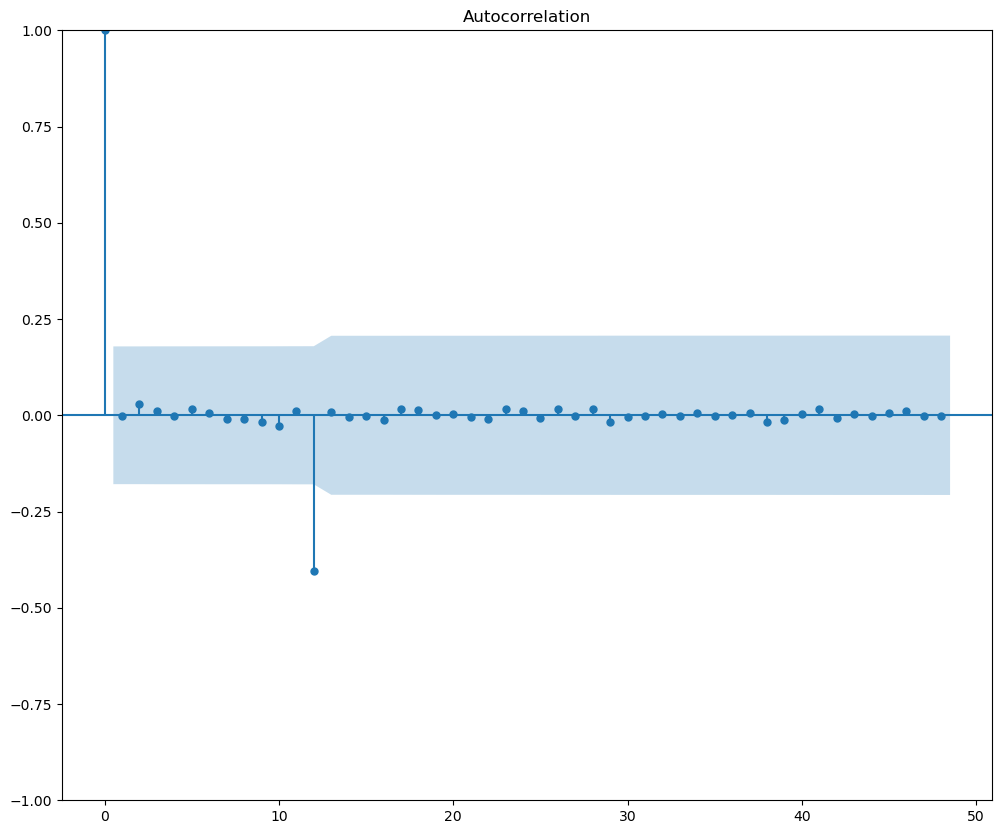

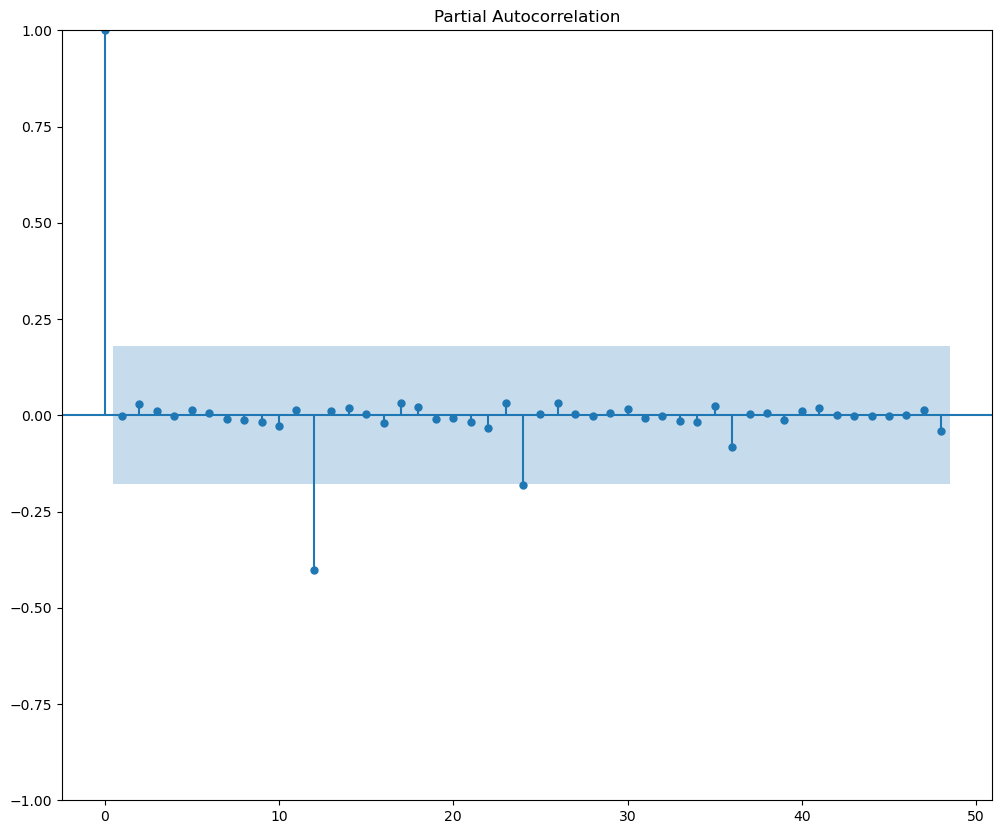

In [83]:
plot_acf(arima_1.resid,lags=48)
plt.show()
plot_pacf(arima_1.resid,lags=48,method='ywm')
plt.show()

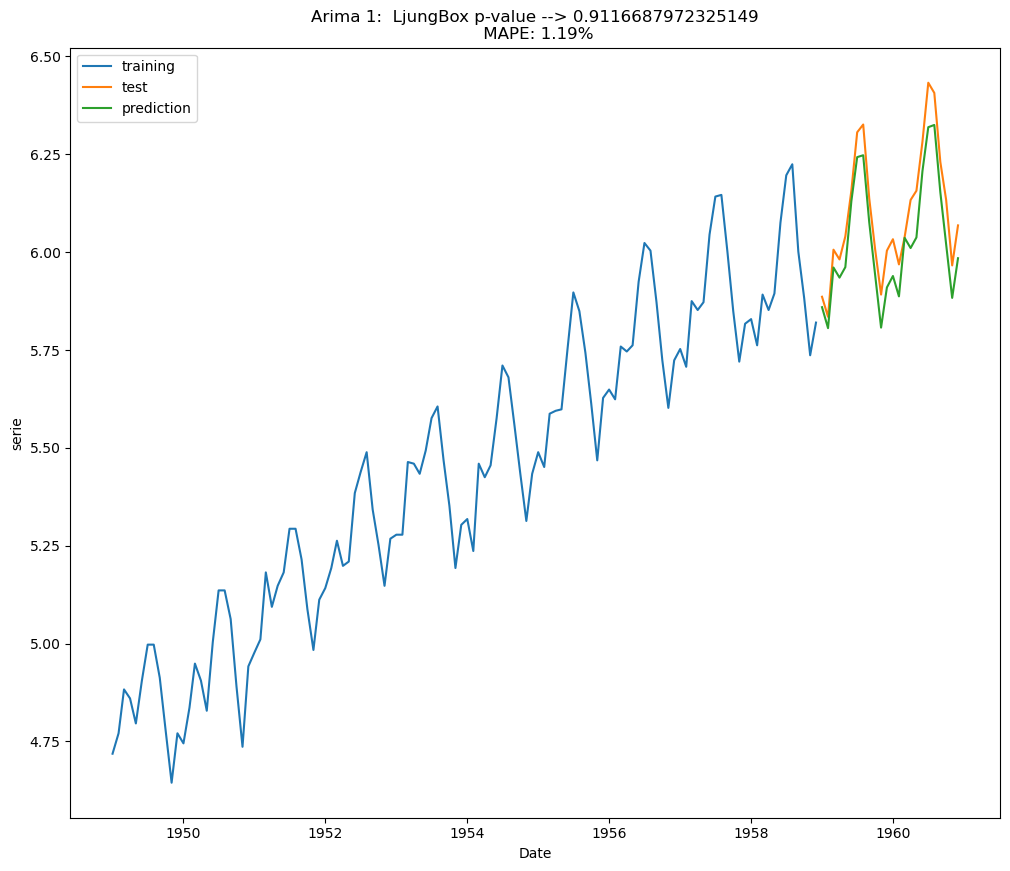

0.9116687972325149


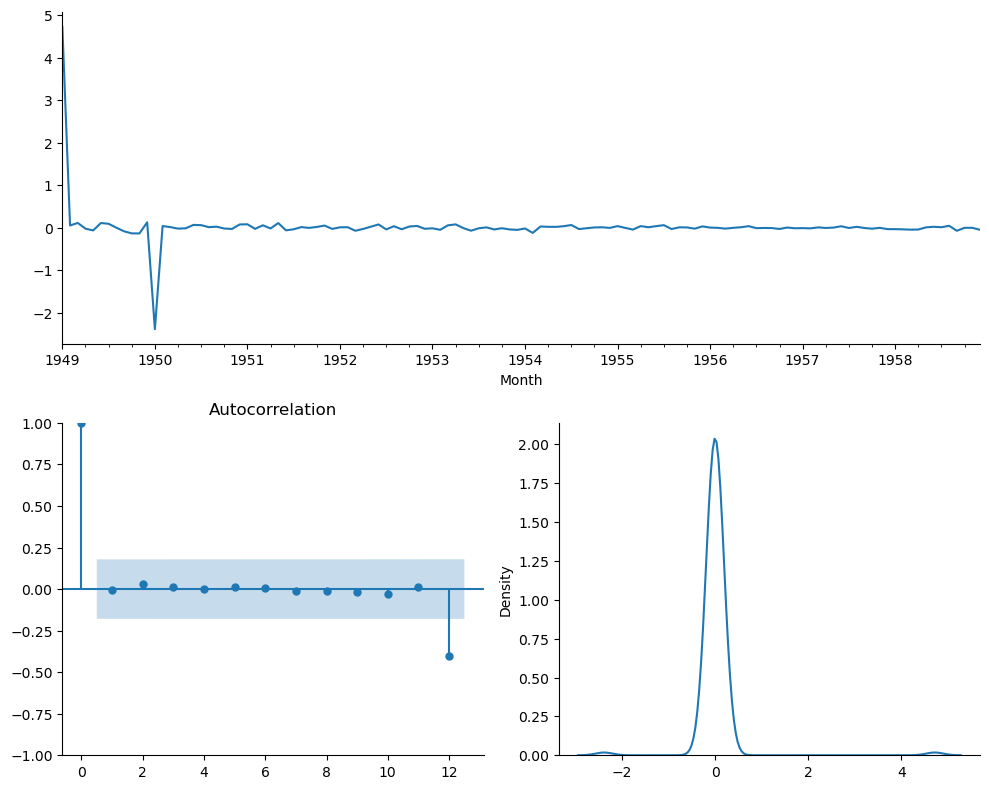

** Mean of the residuals:  0.02

** Ljung Box Test, p-value: 0.912 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<Axes: xlabel='Month'>,
 <Axes: title={'center': 'Autocorrelation'}>,
 <Axes: ylabel='Density'>)

In [85]:
eval_model(arima_1,Air_tr,Air_tst,'Arima 1')

residcheck(arima_1.resid,12)

**Modelo 2** -> Con ambas partes AR



In [87]:
arima2 = SARIMAX(Air_tr, 
                order = (1, 1, 0), 
                seasonal_order =(1, 1, 0, 12))
  
arima_2 = arima2.fit()
arima_2.summary()

C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  120
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 194.679
Date:                            Mon, 21 Apr 2025   AIC                           -383.359
Time:                                    19:53:39   BIC                           -375.340
Sample:                                01-01-1949   HQIC                          -380.108
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3479      0.079     -4.405      0.000      -0.503      -0.193
ar.S.L12      -0.4427      0.076     -5.809      0.000      -0.592      -0.293
sigma2         0.0015      0.000      7.288      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.70
Prob(Q):                              0.91   Prob(JB):                         0.70
Heteroskedasticity (H):               0.33   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

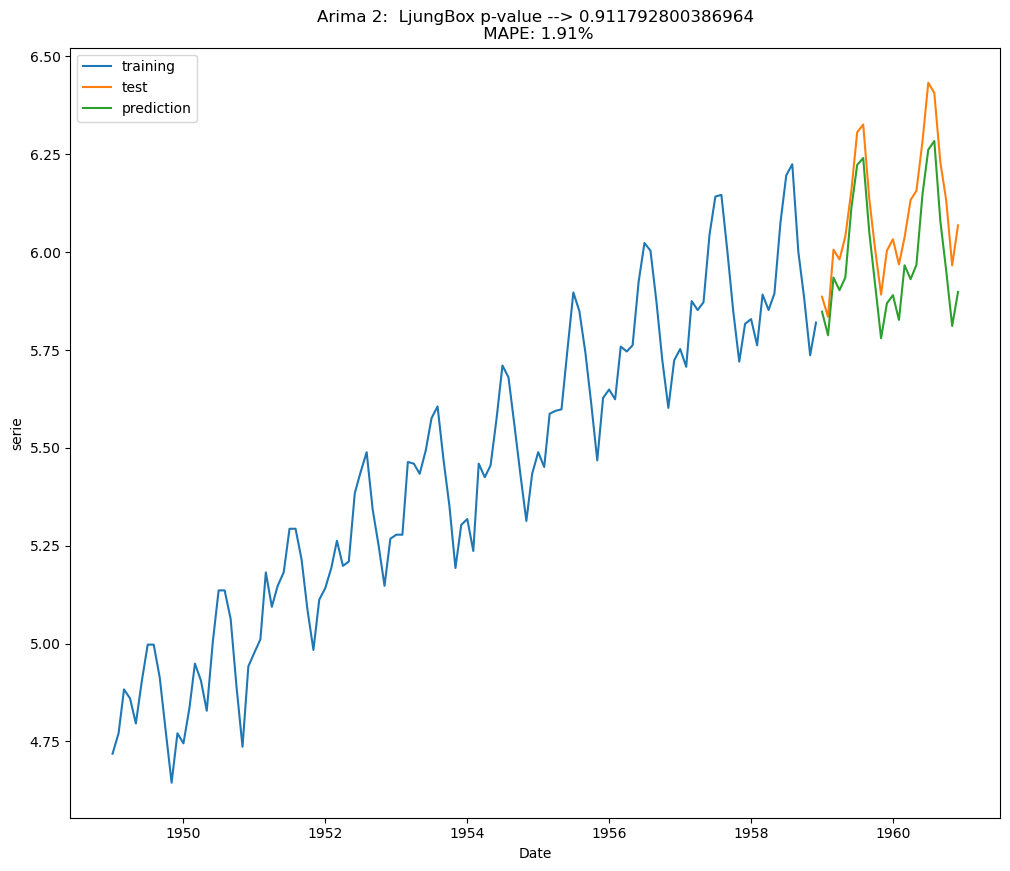

0.911792800386964


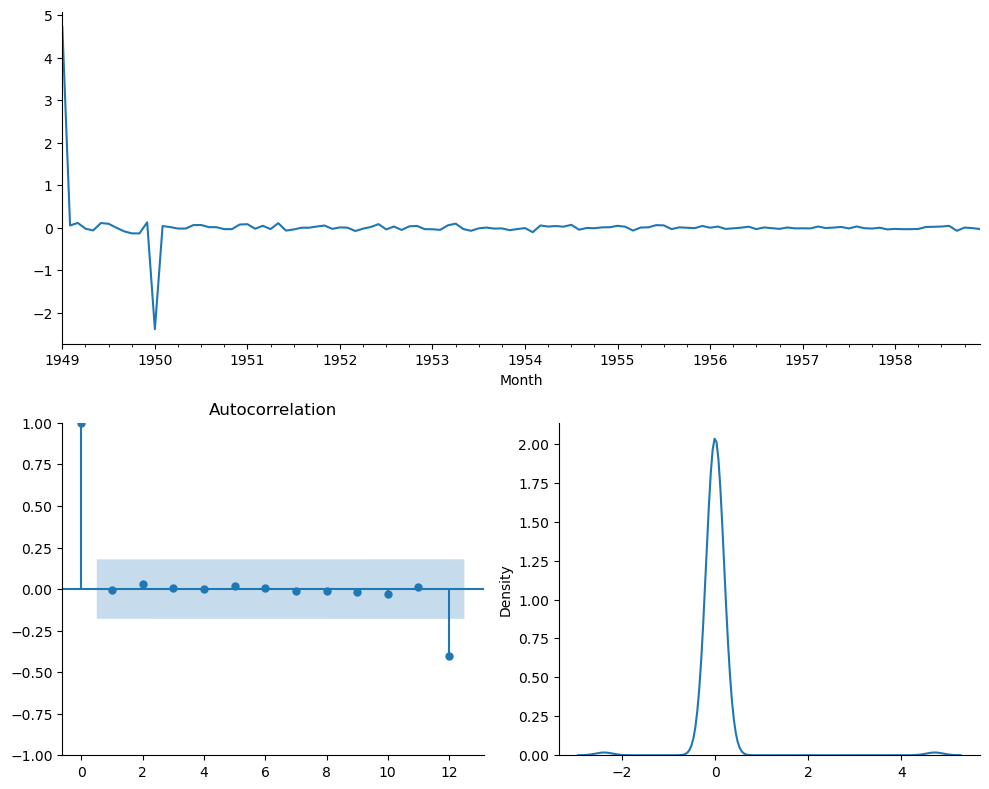

** Mean of the residuals:  0.02

** Ljung Box Test, p-value: 0.912 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<Axes: xlabel='Month'>,
 <Axes: title={'center': 'Autocorrelation'}>,
 <Axes: ylabel='Density'>)

In [89]:
eval_model(arima_2,Air_tr,Air_tst,'Arima 2')

residcheck(arima_2.resid,12)

**Modelo 3** -> Superposición de efectos ARMA en regular y estacional



In [91]:
arima3 = SARIMAX(Air_tr, 
                order = (0, 1, 1), 
                seasonal_order =(1, 0, 1, 12))
  
arima_3 = arima3.fit()
arima_3.summary()

C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 206.711
Date:                            Mon, 21 Apr 2025   AIC                           -405.422
Time:                                    19:54:23   BIC                           -394.306
Sample:                                01-01-1949   HQIC                          -400.908
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2909      0.082     -3.543      0.000      -0.452      -0.130
ar.S.L12       0.9887      0.009    110.244      0.000       0.971       1.006
ma.S.L12      -0.5469      0.107     -5.117      0.000      -0.756      -0.337
sigma2         0.0014      0.000      7.899      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.46
Prob(Q):                              0.89   Prob(JB):                         0.79
Heteroskedasticity (H):               0.43   Skew:                             0.11
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

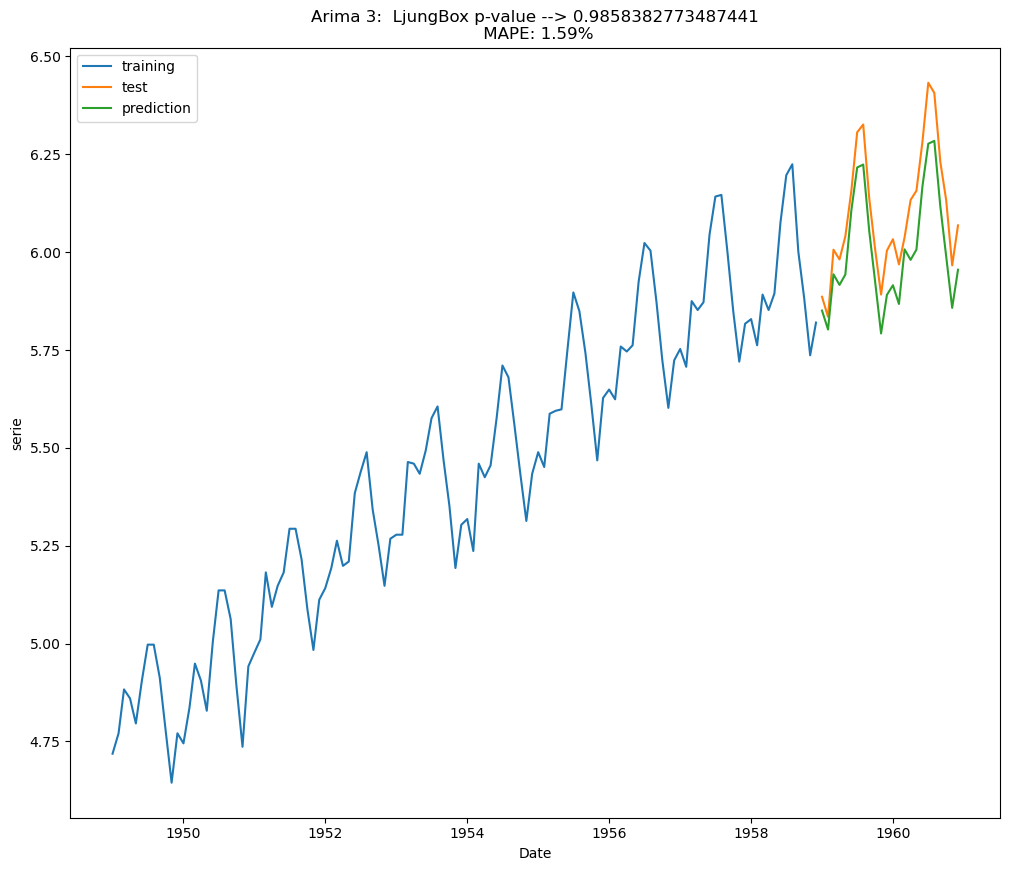

0.9858382773487441


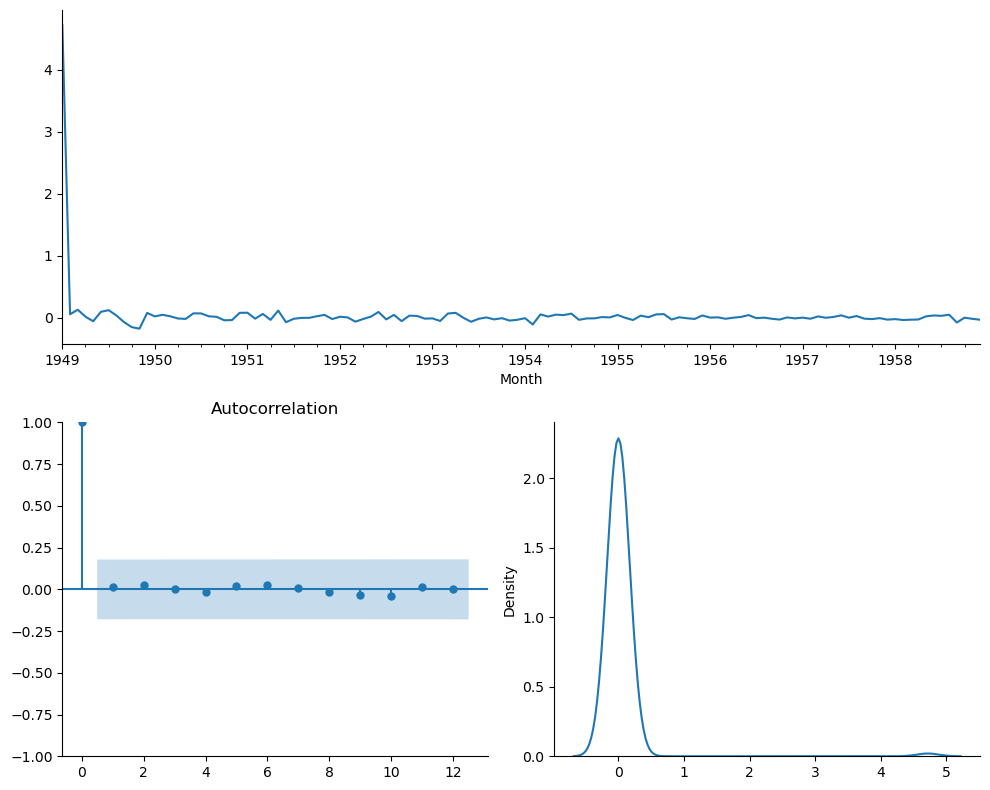

** Mean of the residuals:  0.04

** Ljung Box Test, p-value: 0.986 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<Axes: xlabel='Month'>,
 <Axes: title={'center': 'Autocorrelation'}>,
 <Axes: ylabel='Density'>)

In [93]:
eval_model(arima_3,Air_tr,Air_tst,'Arima 3')
residcheck(arima_3.resid,12)

## ARIMA automático

selección de modelos ARIMA mediante AIC que implementa el paquete *pmdarima*. Se puede jugar bastante con órdenes máximos y mínimos para los efectos autoregresivos y de medias móviles, así como con las diferenciaciones regular y estacional

In [95]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [97]:
import pmdarima as pm

# Ajustamos modelo arima step-wise con métrica AIC para la serie de vuelos
arima_auto = pm.auto_arima(Air_tr, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      #start_P=None, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(arima_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-385.441, Time=0.78 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-353.412, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-383.359, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-389.010, Time=0.28 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-364.326, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-387.220, Time=0.45 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-387.254, Time=0.78 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-384.231, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.38 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-379.989, Time=0.34 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-386.674, Time=0.34 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-387.065, Time=0.44 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-388.643, Time=0.31 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-385.329, Time=0.97 sec
 ARIMA(0,1,1)(0,1,1)[12]

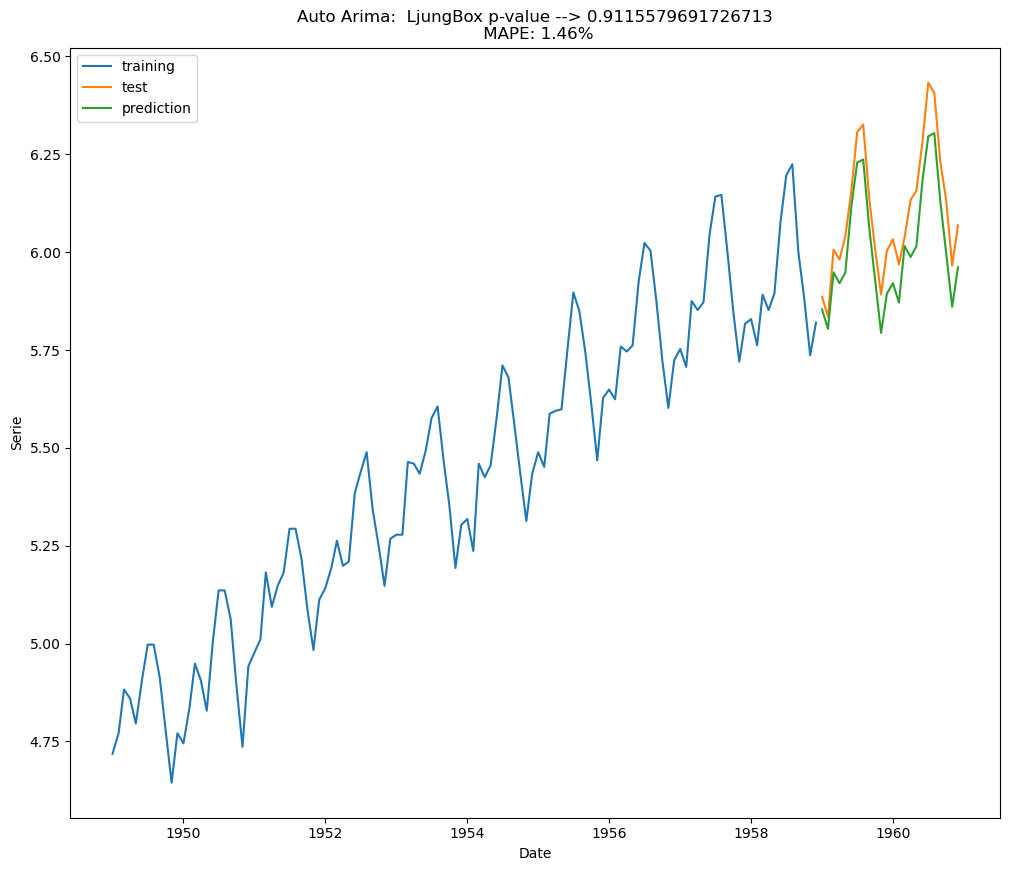

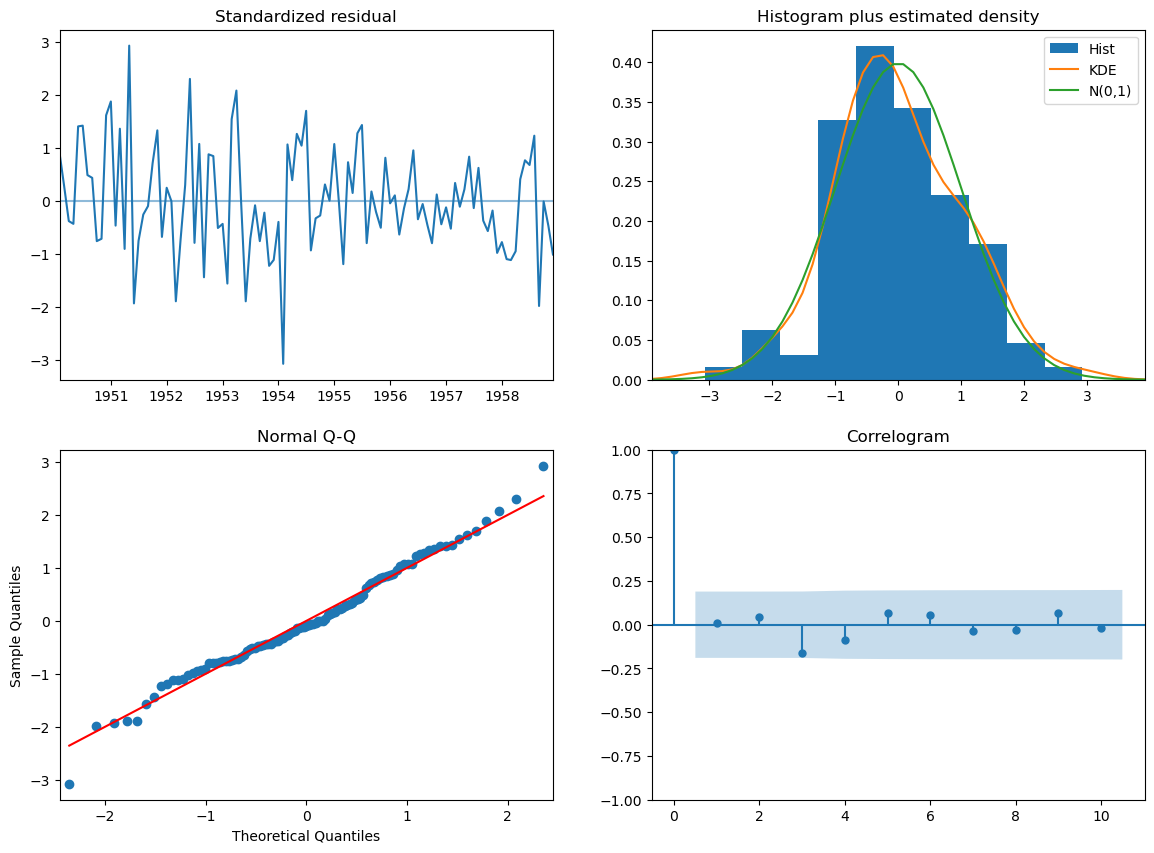

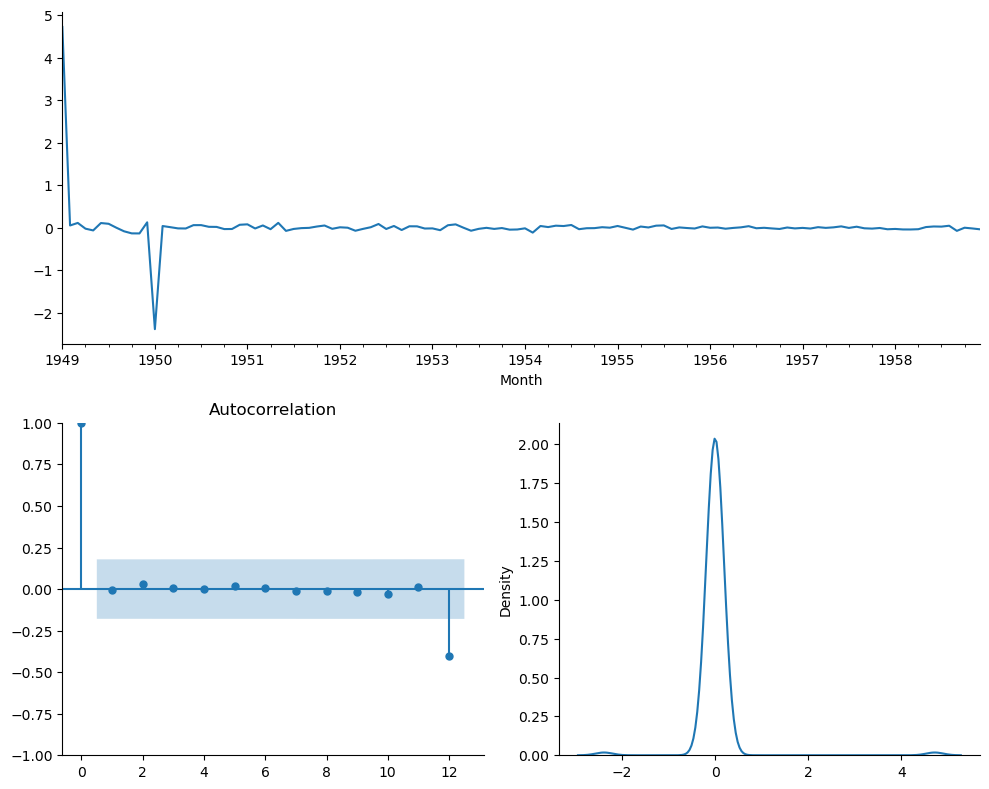

** Mean of the residuals:  0.02

** Ljung Box Test, p-value: 0.912 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<Axes: xlabel='Month'>,
 <Axes: title={'center': 'Autocorrelation'}>,
 <Axes: ylabel='Density'>)

In [99]:
eval_model_Aarima(arima_auto,Air_tr,Air_tst,'Auto Arima')
residcheck(arima_auto.resid(),12)

# Aplicación a Datos sobre viajeros en la ciudad de córdoba 

Ejemplo Cordoba (datos Cordoba.xlsx), donde trataremos de explorar los mejores modelos de suavizado y arima para las dos series que contiene. 


In [101]:
#Lectura de datos
Cordoba = pd.read_excel(r'C:\Users\Usuario\Documents\CIENCIA DE DATOS\REPOSITORIO GITHUB\MINERÍA DE DATOS Y MODELACIÓN ejercicios\3. Ejercicio base datos pasajeros\script_base_pasajeros_suav_arima\Cordoba.xlsx')
Cordoba.head()

V_Resident  V_Extranj
0  2005M01       27816       9332
1  2005M02       34920      11387
2  2005M03       45221      21663
3  2005M04       41027      29094
4  2005M05       50750      32076

Cambiamos la M típica del INE por un guion para generar la fecha correctamente. 



In [103]:
Cordoba['Month'] = Cordoba.iloc[:,0].apply(lambda x: x.replace('M','-'))

In [105]:
Cordoba = Cordoba.iloc[:,1:]
Cordoba.head()


V_Resident  V_Extranj    Month
0       27816       9332  2005-01
1       34920      11387  2005-02
2       45221      21663  2005-03
3       41027      29094  2005-04
4       50750      32076  2005-05

Convertir a serie temporal con la fecha indexada.



In [107]:
Cordoba.set_index(['Month'],inplace=True)
Cordoba.index=pd.to_datetime(Cordoba.index)

In [109]:
Cordoba.head()

V_Resident  V_Extranj
Month                            
2005-01-01       27816       9332
2005-02-01       34920      11387
2005-03-01       45221      21663
2005-04-01       41027      29094
2005-05-01       50750      32076

Tenemos la serie de viajeros residentes y la de viajeros extranjeros. Nos preguntamos si se comportan igual en cuanto al turismo en Córdoba. 



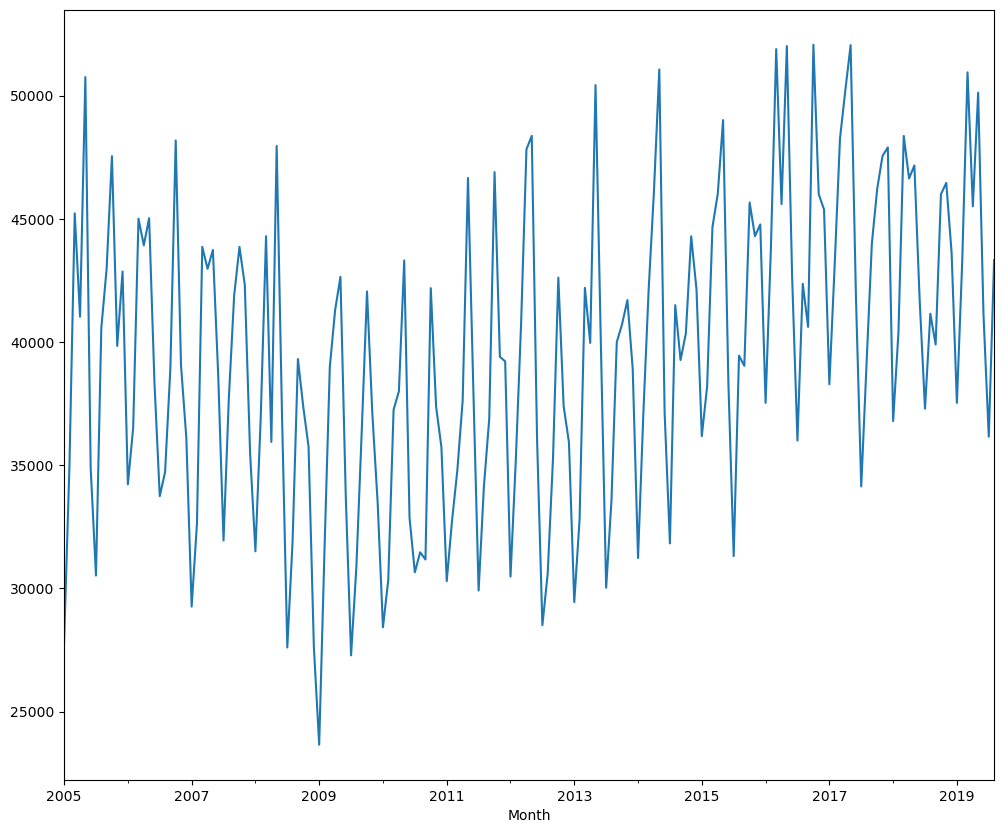

In [111]:
Cordoba.V_Resident.plot()
plt.show()

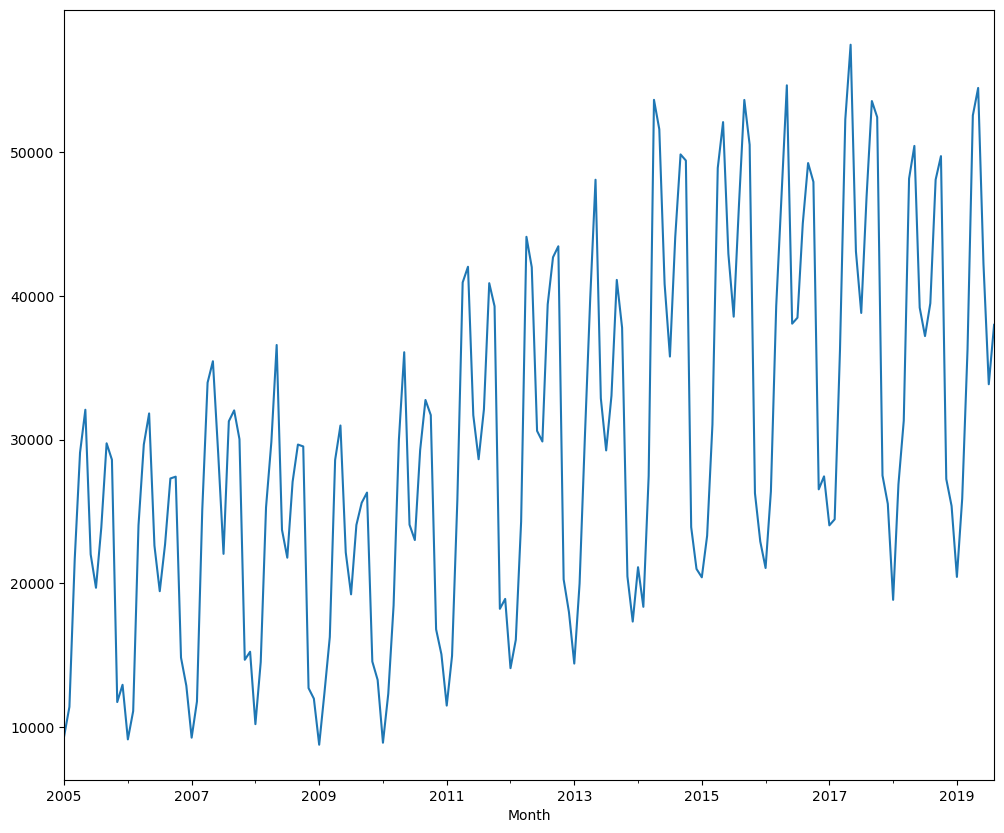

In [113]:
Cordoba.V_Extranj.plot()
plt.show()

Evaluar la estacionariedad de las series al natural.



In [115]:
test_stationarity(Cordoba.V_Extranj)
test_stationarity(Cordoba.V_Resident)

Results of Dickey-Fuller Test:
Test Statistic                  -2.121733
p-value                          0.533907
#Lags Used                      14.000000
Number of Observations Used    161.000000
Critical Value (1%)             -4.016129
Critical Value (5%)             -3.438119
Critical Value (10%)            -3.143266
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -2.200183
p-value                          0.489748
#Lags Used                      12.000000
Number of Observations Used    163.000000
Critical Value (1%)             -4.015411
Critical Value (5%)             -3.437776
Critical Value (10%)            -3.143065
dtype: float64


**Descomposición multiplicativa**



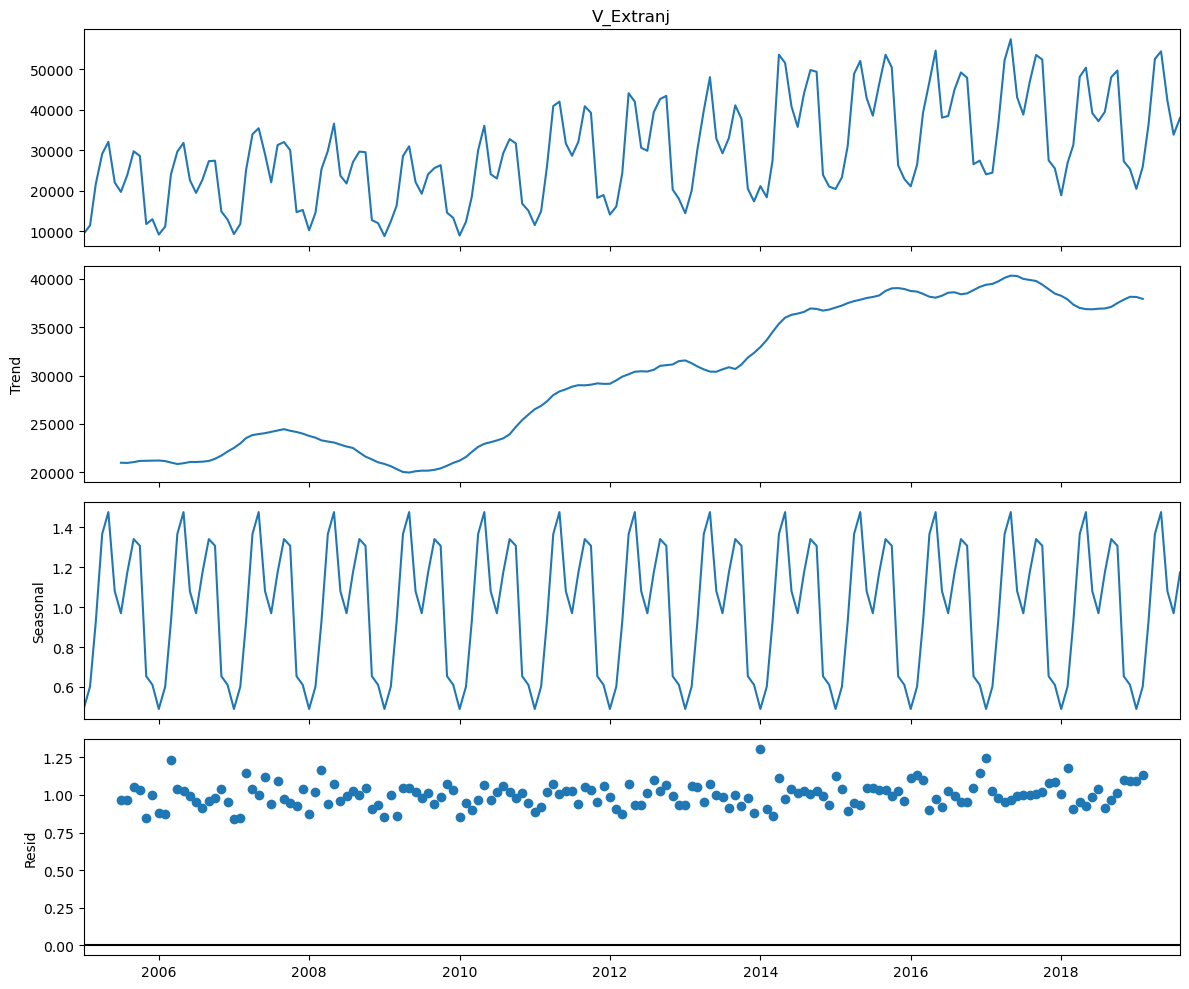

In [117]:
# Aplicar descomposición aditiva
result_E = seasonal_decompose(Cordoba.V_Extranj, model='multiplicative',period=12)
result_E.plot()
plt.show()

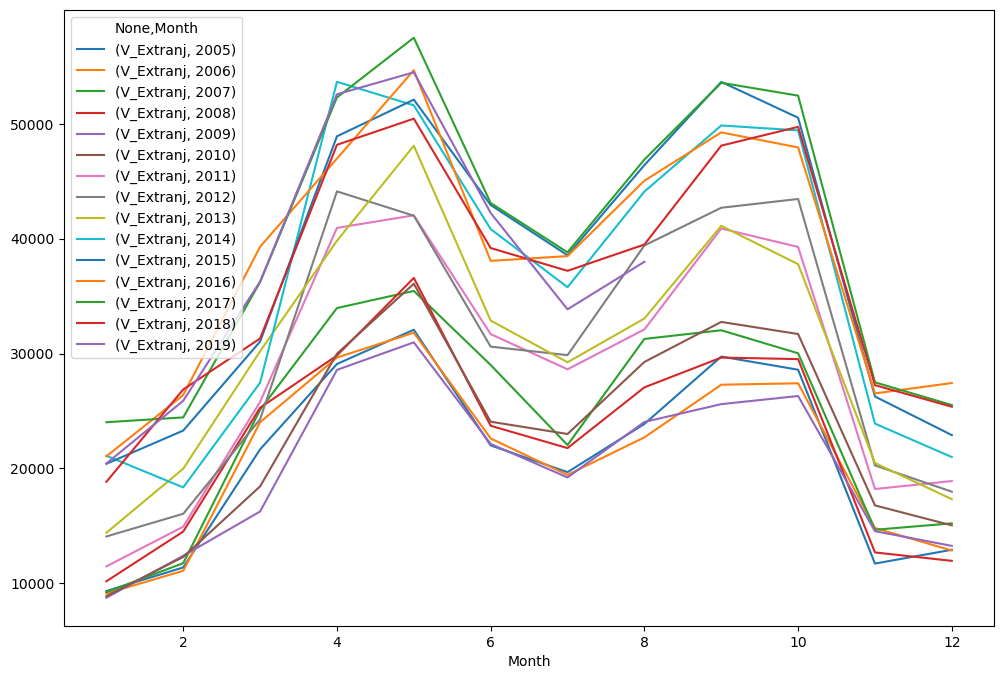

Results of Dickey-Fuller Test:
Test Statistic                -7.290593e+00
p-value                        3.081450e-09
#Lags Used                     9.000000e+00
Number of Observations Used    1.540000e+02
Critical Value (1%)           -4.018792e+00
Critical Value (5%)           -3.439393e+00
Critical Value (10%)          -3.144011e+00
dtype: float64


In [119]:
# Gráfico de estacionalidad
seasonal_plot(Cordoba,column='V_Extranj')
plt.show()

# Test de estacionariedad para los residuos
test_stationarity(result_E.resid.dropna())

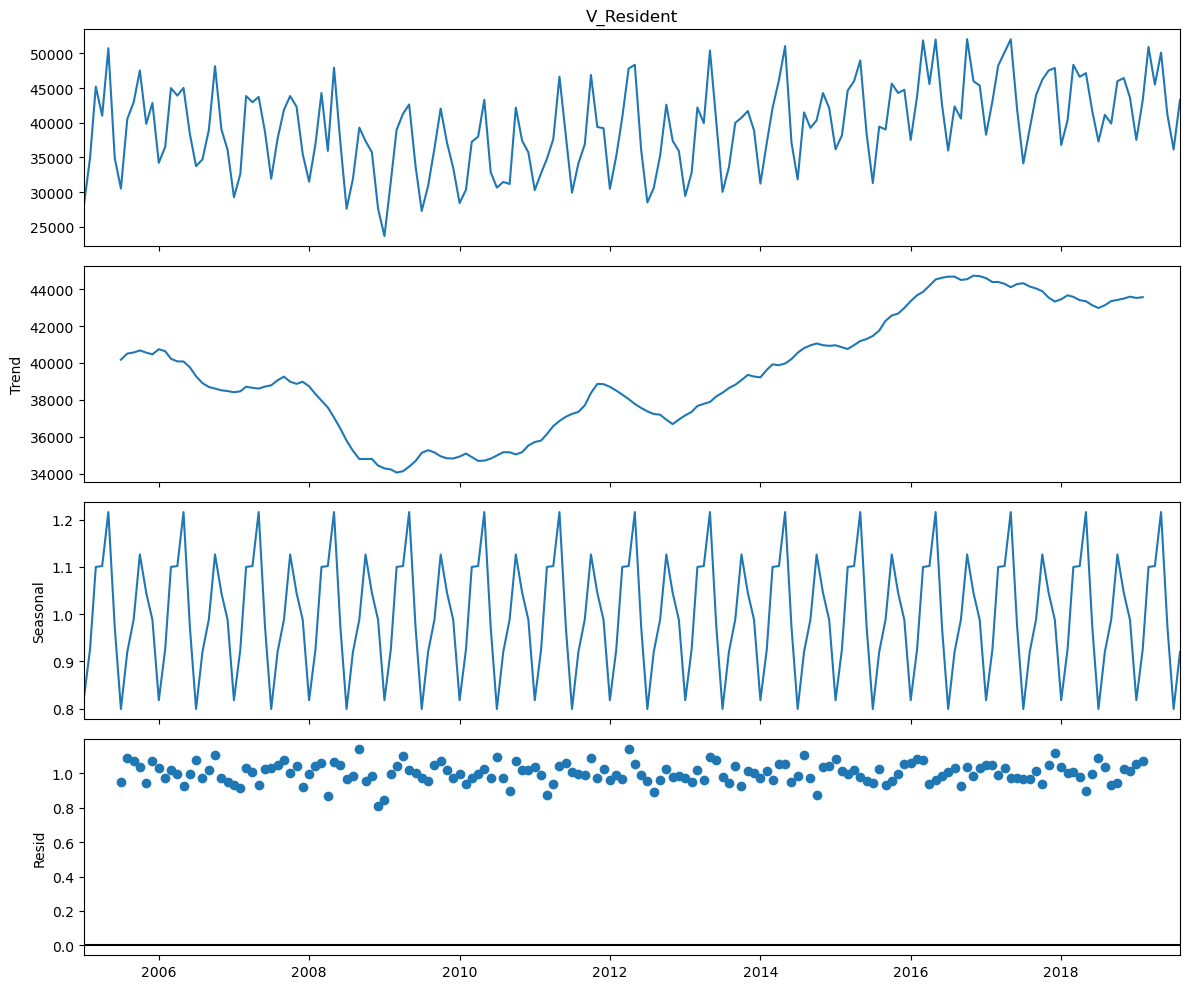

In [121]:
# Aplicar descomposición aditiva
result_R = seasonal_decompose(Cordoba.V_Resident, model='multiplicative',period=12)
result_R.plot()
plt.show()

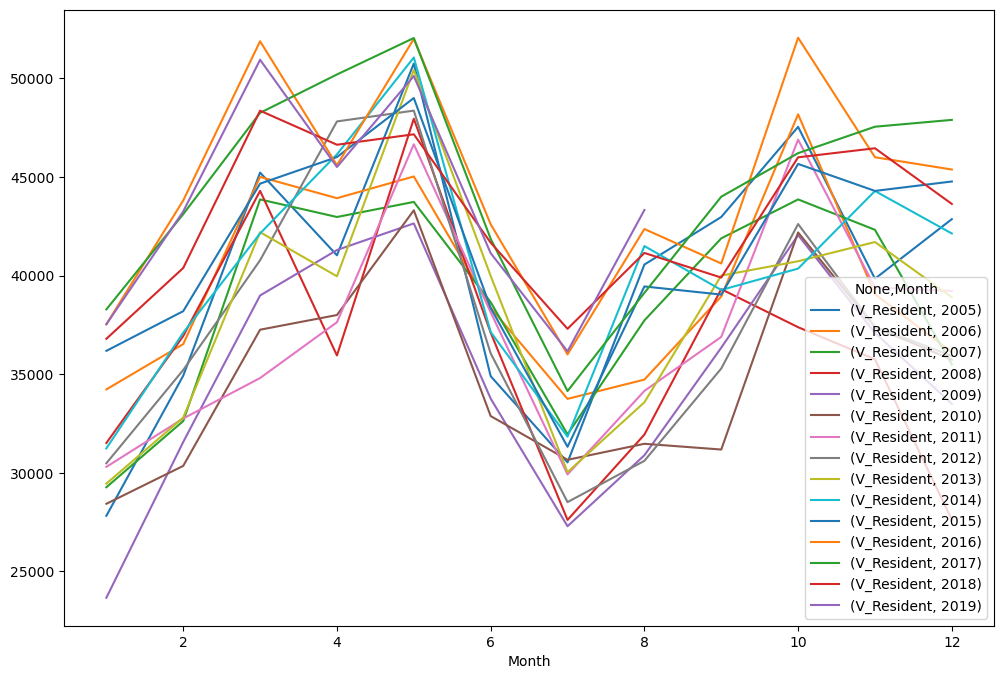

Results of Dickey-Fuller Test:
Test Statistic                -7.386349e+00
p-value                        1.859340e-09
#Lags Used                     9.000000e+00
Number of Observations Used    1.540000e+02
Critical Value (1%)           -4.018792e+00
Critical Value (5%)           -3.439393e+00
Critical Value (10%)          -3.144011e+00
dtype: float64


In [123]:
# Gráfico de estacionalidad
seasonal_plot(Cordoba)
plt.show()

# Test de estacionariedad para los residuos
test_stationarity(result_R.resid.dropna())

Gráficos de aurocorrelación de residuos con bandas de confianza.



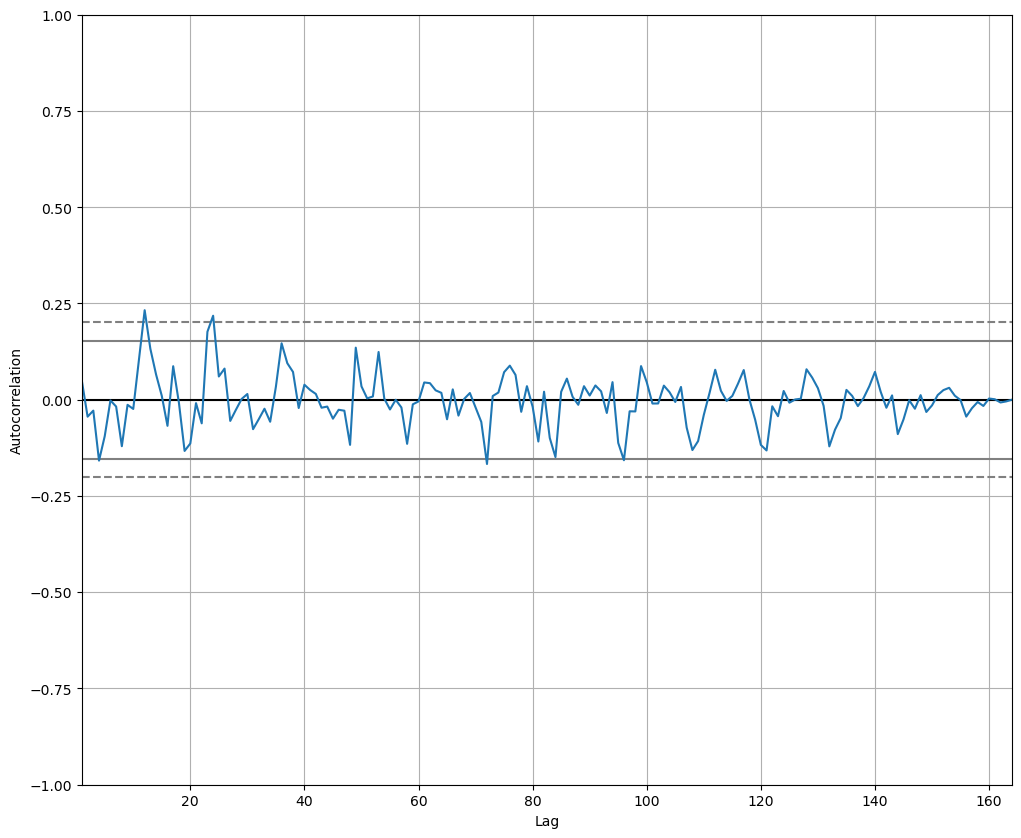

In [125]:
autocorrelation_plot(result_E.resid.dropna())
plt.show()

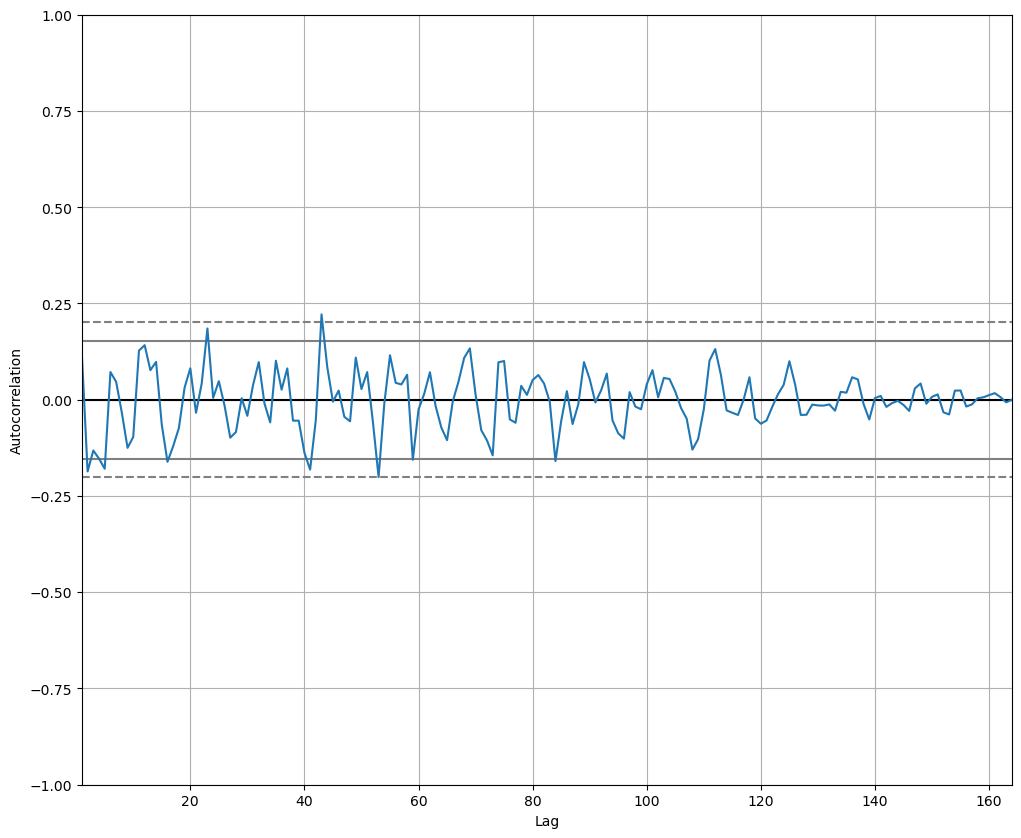

In [127]:
autocorrelation_plot(result_R.resid.dropna())
plt.show()

Contraste de Ljung-Box para residuos de la descomposición multiplicativa



In [129]:
sm.stats.acorr_ljungbox(result_E.resid.dropna(), lags=12, return_df=True)

lb_stat  lb_pvalue
1    0.390086   0.532254
2    0.715787   0.699147
3    0.851541   0.837103
4    5.112490   0.275949
5    6.650613   0.247948
6    6.651175   0.354314
7    6.705458   0.460178
8    9.249181   0.321714
9    9.280102   0.411830
10   9.381525   0.496318
11  11.289299   0.419355
12  20.972195   0.050789

In [131]:
sm.stats.acorr_ljungbox(result_R.resid.dropna(), lags=12, return_df=True)

lb_stat  lb_pvalue
1    2.237791   0.134673
2    8.071325   0.017674
3   11.011894   0.011662
4   14.998395   0.004705
5   20.502372   0.001005
6   21.391819   0.001560
7   21.768829   0.002784
8   21.966624   0.004978
9   24.710894   0.003308
10  26.363710   0.003281
11  29.257182   0.002070
12  32.849279   0.001022

**Partición training-test**



In [133]:
Cordoba_tr = Cordoba[:'2017-12-01']
Cordoba_tst = Cordoba['2018-01-01':]

## Modelos de Suavizado

En esta sección vamos a ajustar modelos de suavizado que parezcar realistas para estas series. Es evidente que nada de simple y doble y nos vamos a Holt Winters. Vamos a probar aditivo y multiplicativo para ambas series.

1. **Extranjeros**

Modelo aditivo.


C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


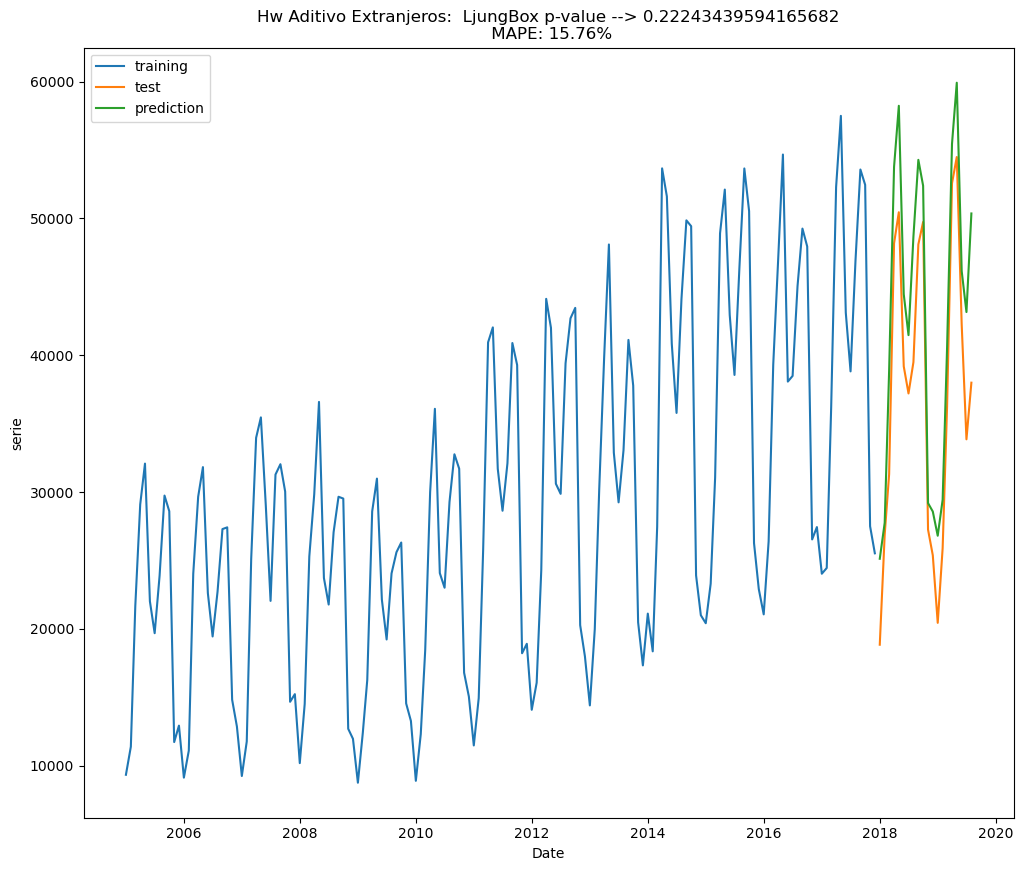

0.22243439594165682


In [135]:
hw_add = ets.ExponentialSmoothing(Cordoba_tr.V_Extranj,trend='add', damped_trend=False, seasonal='add').fit()
eval_model(hw_add,Cordoba_tr.V_Extranj,Cordoba_tst.V_Extranj,'Hw Aditivo Extranjeros')

Modelo multiplicativo. 



C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


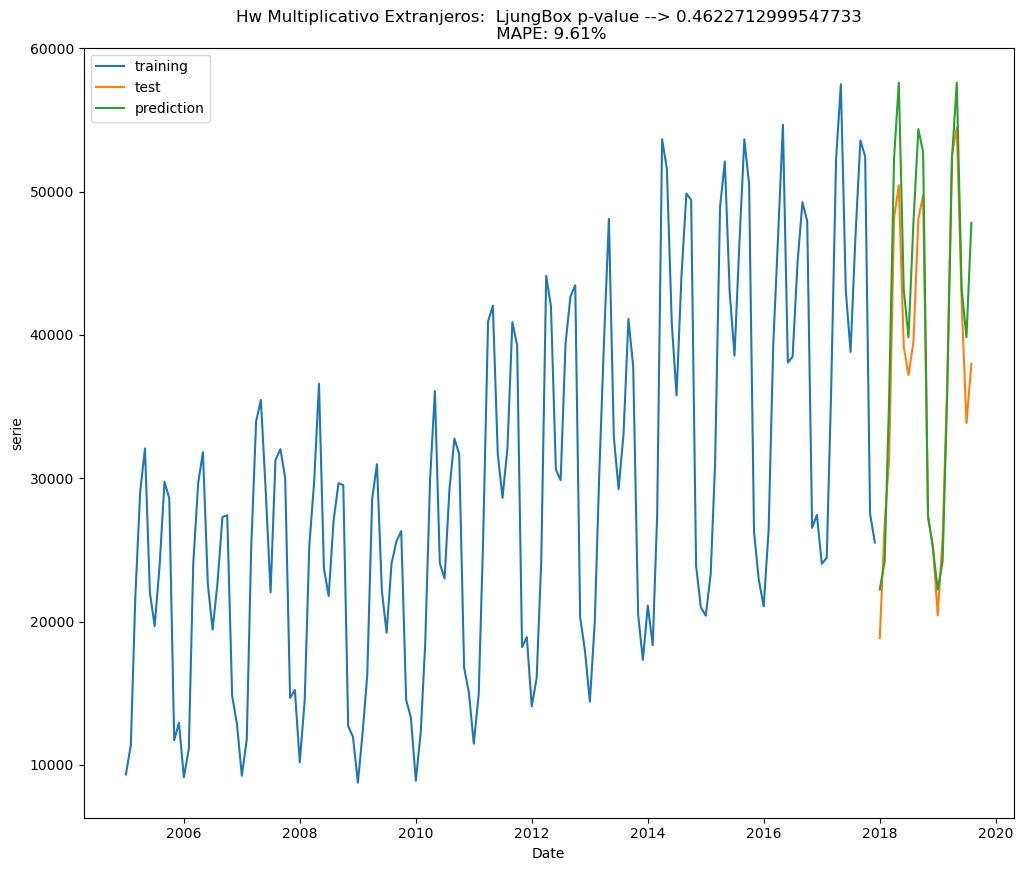

0.4622712999547733


In [137]:
hw_mul = ets.ExponentialSmoothing(Cordoba_tr.V_Extranj,trend='mul', damped_trend=False, seasonal='mul').fit()
eval_model(hw_mul,Cordoba_tr.V_Extranj,Cordoba_tst.V_Extranj,'Hw Multiplicativo Extranjeros')

2. **Residentes**

Modelo aditivo.


C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


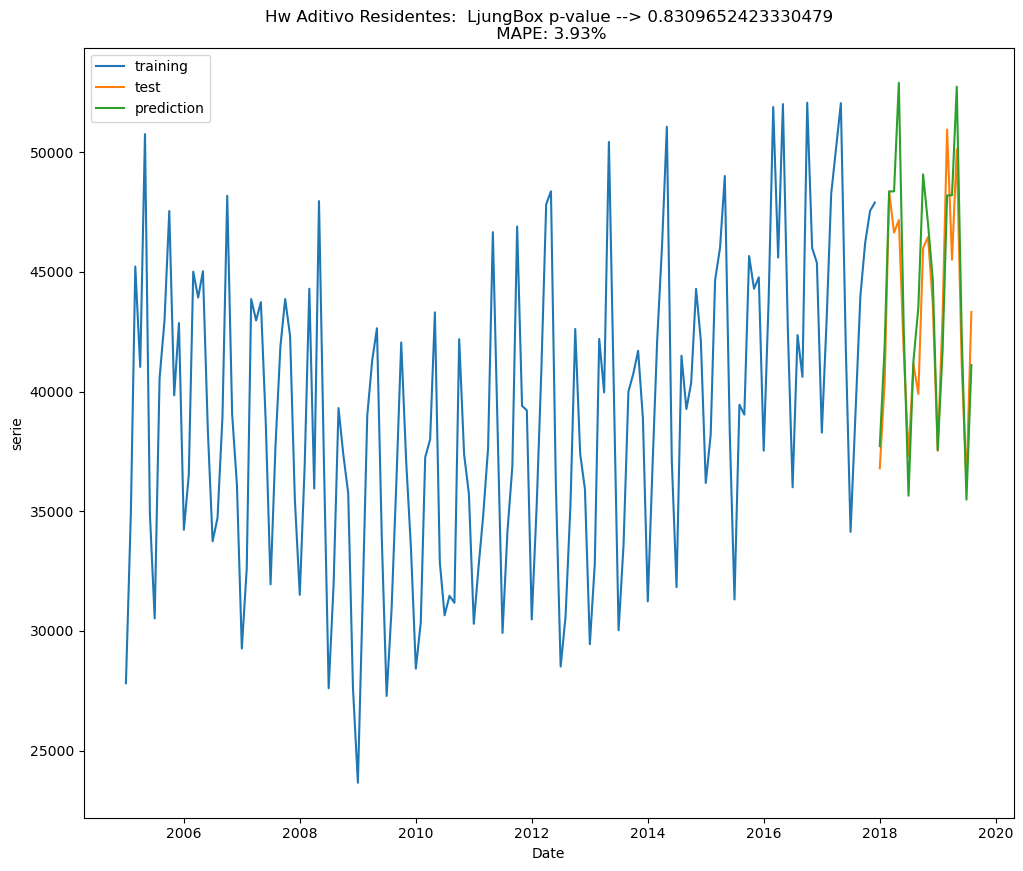

0.8309652423330479


In [139]:
hw_add = ets.ExponentialSmoothing(Cordoba_tr.V_Resident,trend='add', damped_trend=False, seasonal='add').fit()
eval_model(hw_add,Cordoba_tr.V_Resident,Cordoba_tst.V_Resident,'Hw Aditivo Residentes')

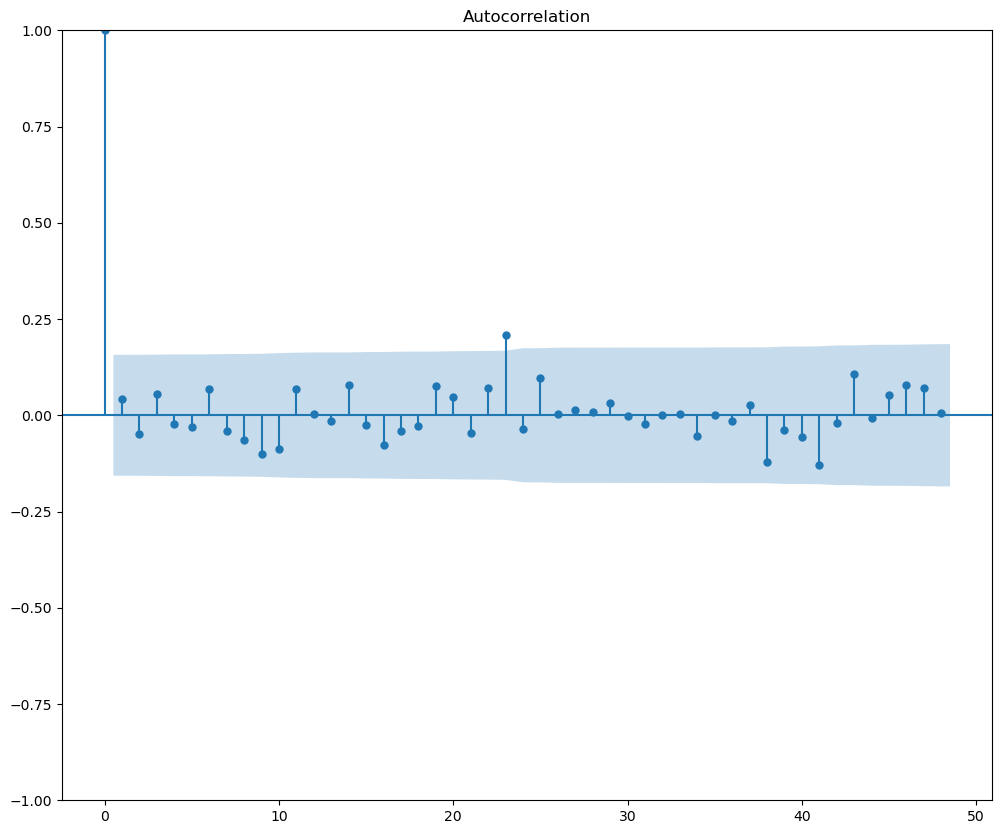

In [141]:
plot_acf(hw_add.resid.dropna(inplace=False),lags=48)
plt.show()

Modelo multiplicativo.



C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


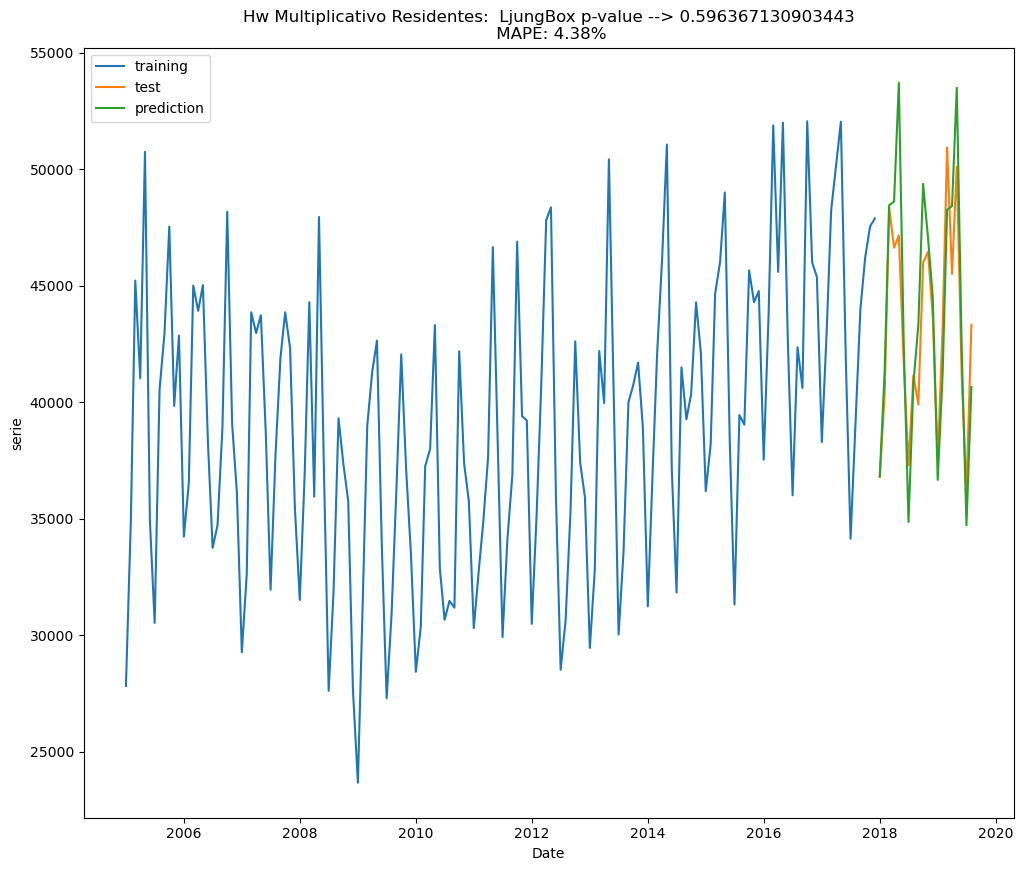

0.596367130903443


In [143]:
hw_mul = ets.ExponentialSmoothing(Cordoba_tr.V_Resident,trend='mul', damped_trend=False, seasonal='mul').fit()
eval_model(hw_mul,Cordoba_tr.V_Resident,Cordoba_tst.V_Resident,'Hw Multiplicativo Residentes')

## Modelos ARIMA

1. **Extranjeros**

Vistazo a correlogramas.


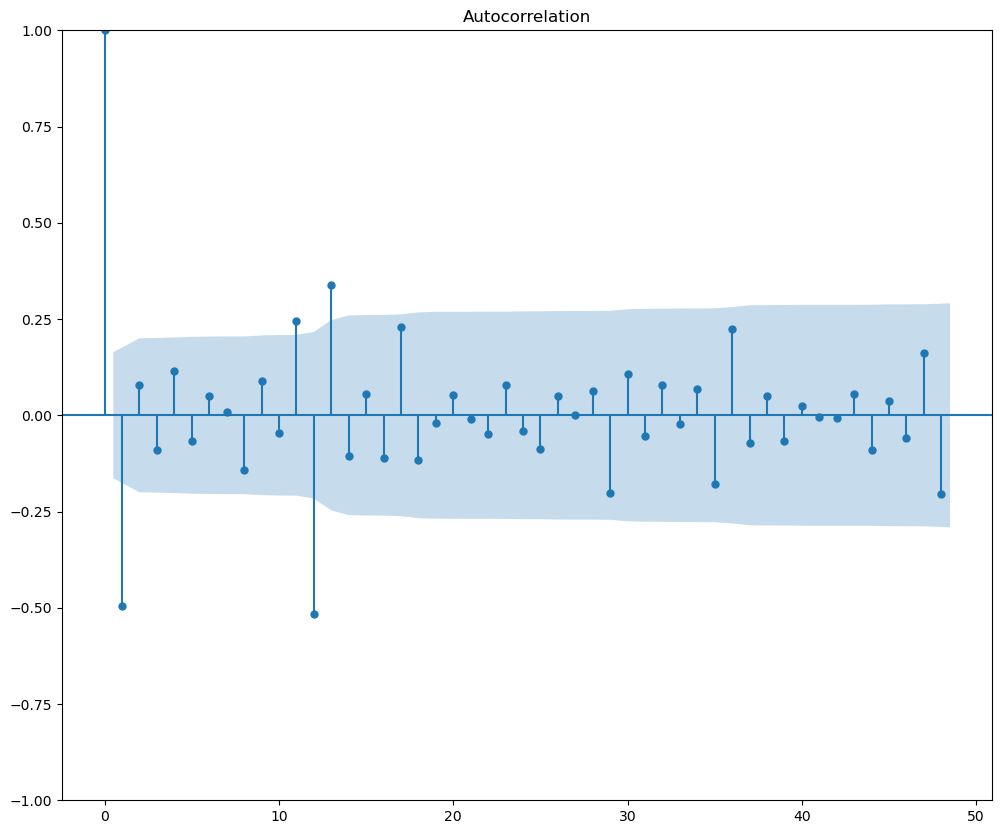

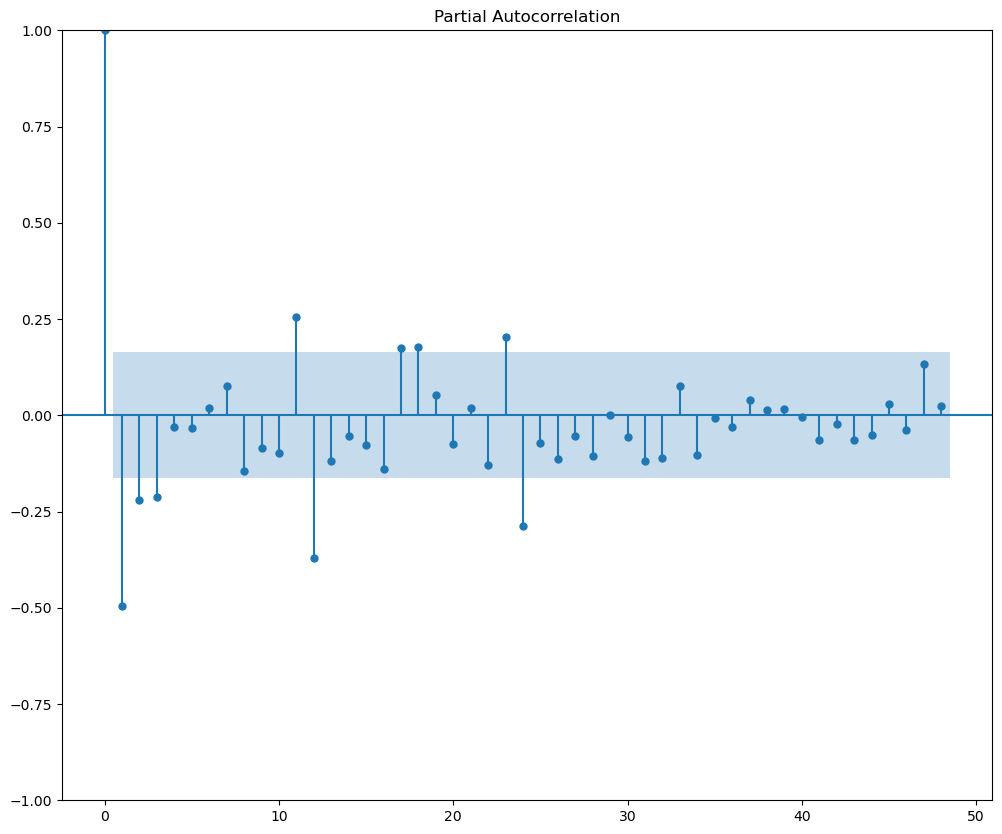

In [145]:
Extranj_diff_1_12 = Cordoba_tr.V_Extranj.diff(periods=1).diff(periods=12)

plot_acf(Extranj_diff_1_12.dropna(inplace=False),lags=48)
plt.show()
plot_pacf(Extranj_diff_1_12.dropna(inplace=False),lags=48,method='ywm')
plt.show()

ACF que se corta en retardo 1, parece Ma 1 en lo regular. También hay corte en retardo 12, huele a MA 1 estacional. 
PACF confirma un poco las sospechas, podríamos decir decrecimiento geométrico en lo regular pero podría haber bajada desde el retardo 1 por lo que podría enmascarar un AR 1.. En lo estacional, decrecimiento, parece MA. 

Asi pues, podemos proponer algo como ARIMA(0-1,1,1)(0,1,1)[12] y jugar un poco por ahí. 


**Arima Manual**


In [147]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
arima1 = SARIMAX(Cordoba_tr.V_Extranj, 
                order = (0, 1, 1), 
                seasonal_order =(0, 1, 1, 12))
  
arima_1 = arima1.fit()
arima_1.summary()

C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          V_Extranj   No. Observations:                  156
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1348.235
Date:                            Mon, 21 Apr 2025   AIC                           2702.470
Time:                                    20:07:48   BIC                           2711.359
Sample:                                01-01-2005   HQIC                          2706.082
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5649      0.058     -9.741      0.000      -0.679      -0.451
ma.S.L12      -0.4795      0.065     -7.352      0.000      -0.607      -0.352
sigma2      8.663e+06   7.82e+05     11.085      0.000    7.13e+06    1.02e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                17.18
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                             0.40
Prob(H) (two-sided):                  0.14   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

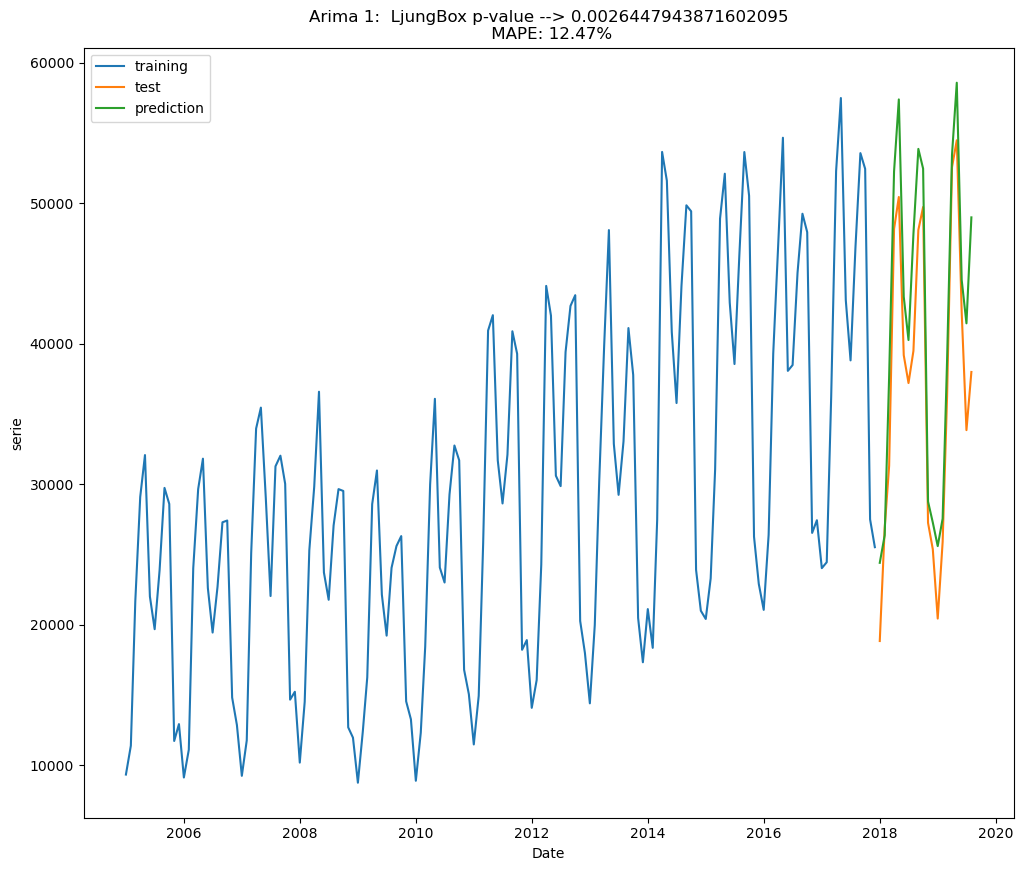

0.0026447943871602095


In [149]:
eval_model(arima_1,Cordoba_tr.V_Extranj,Cordoba_tst.V_Extranj,'Arima 1')

In [151]:
arima2 = SARIMAX(Cordoba_tr.V_Extranj, 
                order = (1, 1, 1), 
                seasonal_order =(0, 1, 1, 12))
  
arima_2 = arima2.fit()
arima_2.summary()

C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          V_Extranj   No. Observations:                  156
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1348.099
Date:                            Mon, 21 Apr 2025   AIC                           2704.197
Time:                                    20:08:18   BIC                           2716.049
Sample:                                01-01-2005   HQIC                          2709.013
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0793      0.158      0.503      0.615      -0.230       0.389
ma.L1         -0.6163      0.119     -5.182      0.000      -0.849      -0.383
ma.S.L12      -0.4903      0.068     -7.202      0.000      -0.624      -0.357
sigma2      8.643e+06   7.85e+05     11.013      0.000    7.11e+06    1.02e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                18.82
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               1.52   Skew:                             0.40
Prob(H) (two-sided):                  0.15   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

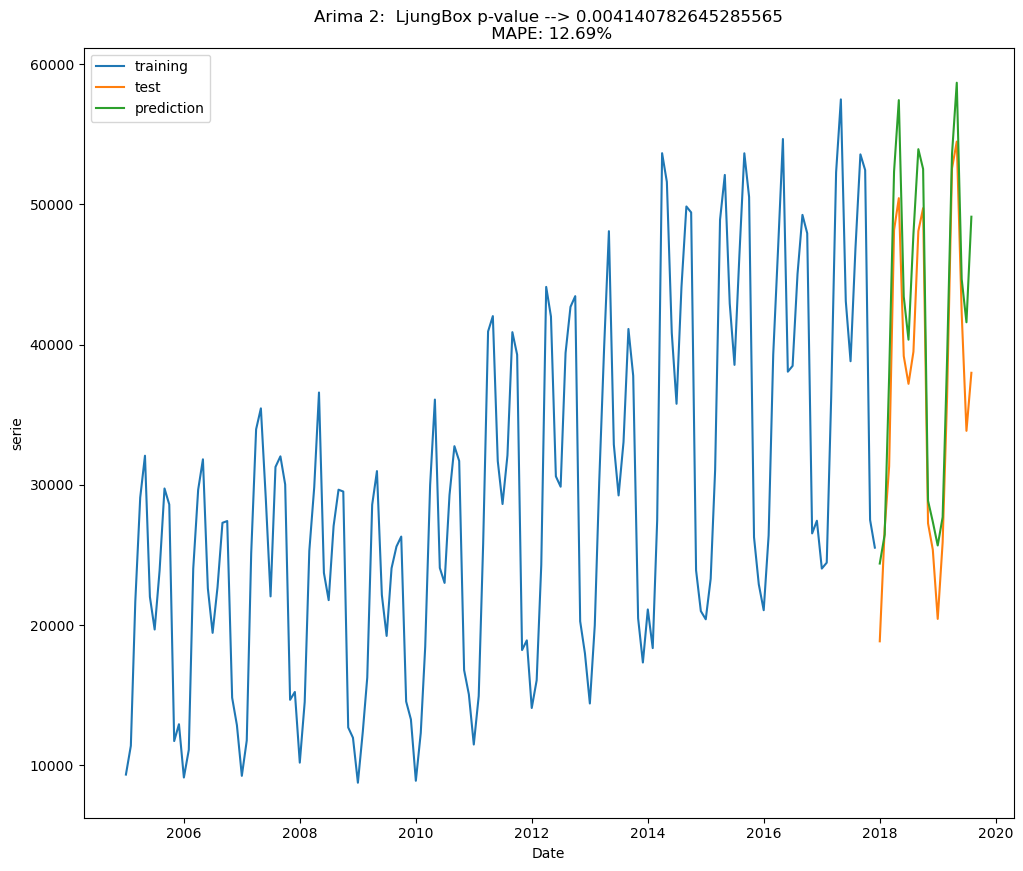

0.004140782645285565


In [153]:
eval_model(arima_2,Cordoba_tr.V_Extranj,Cordoba_tst.V_Extranj,'Arima 2')

Probamos adiferenciar de orden 2 en lo regular.



In [155]:
arima3 = SARIMAX(Cordoba_tr.V_Extranj, 
                order = (1, 2, 2), 
                seasonal_order =(0, 1, 1, 12))
  
arima_3 = arima3.fit()
arima_3.summary()

C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            V_Extranj   No. Observations:                  156
Model:             SARIMAX(1, 2, 2)x(0, 1, [1], 12)   Log Likelihood               -1350.874
Date:                              Mon, 21 Apr 2025   AIC                           2711.747
Time:                                      20:08:40   BIC                           2726.526
Sample:                                  01-01-2005   HQIC                          2717.753
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1125      0.196      0.574      0.566      -0.272       0.496
ma.L1         -1.5432      0.193     -8.005      0.000      -1.921      -1.165
ma.L2          0.5442      0.187      2.917      0.004       0.178       0.910
ma.S.L12      -0.5216      0.078     -6.669      0.000      -0.675      -0.368
sigma2      1.013e+07   2.28e-08   4.45e+14      0.000    1.01e+07    1.01e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                10.52
Prob(Q):                              0.57   Prob(JB):                         0.01
Heteroskedasticity (H):               1.02   Skew:                             0.32
Prob(H) (two-sided):                  0.96   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.02e+30. Standard errors may be unstable.
"""

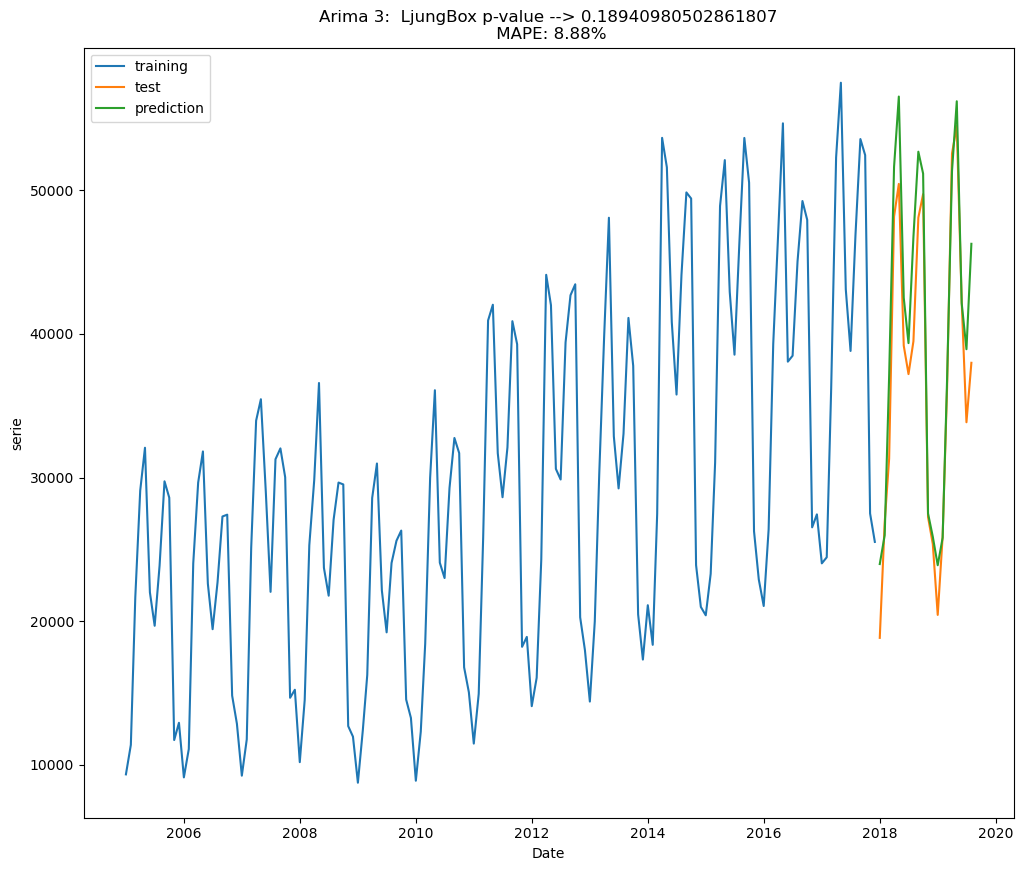

0.18940980502861807


In [157]:
eval_model(arima_3,Cordoba_tr.V_Extranj,Cordoba_tst.V_Extranj,'Arima 3')

Auto ARIMA 

Vamos a aplicar automatismos para buscar los mejores órdenes en relación al AIC utilizando auro_arima.


In [159]:
# Auto arima
arima_auto = pm.auto_arima(Cordoba_tr.V_Extranj, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=2,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      #start_P=None, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(arima_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,1,1)[12]             : AIC=inf, Time=0.87 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=2924.228, Time=0.04 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=2807.137, Time=0.13 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=2837.587, Time=0.05 sec
 ARIMA(1,2,0)(2,1,0)[12]             : AIC=2799.067, Time=0.29 sec
 ARIMA(1,2,0)(2,1,1)[12]             : AIC=2800.645, Time=0.57 sec
 ARIMA(1,2,0)(1,1,1)[12]             : AIC=2794.444, Time=0.50 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=2799.773, Time=0.31 sec
 ARIMA(1,2,0)(1,1,2)[12]             : AIC=inf, Time=2.41 sec
 ARIMA(1,2,0)(0,1,2)[12]             : AIC=2793.990, Time=1.27 sec
 ARIMA(0,2,0)(0,1,2)[12]             : AIC=2859.093, Time=0.68 sec
 ARIMA(2,2,0)(0,1,2)[12]             : AIC=2770.998, Time=1.35 sec
 ARIMA(2,2,0)(0,1,1)[12]             : AIC=2775.698, Time=0.18 sec
 ARIMA(2,2,0)(1,1,2)[12]          

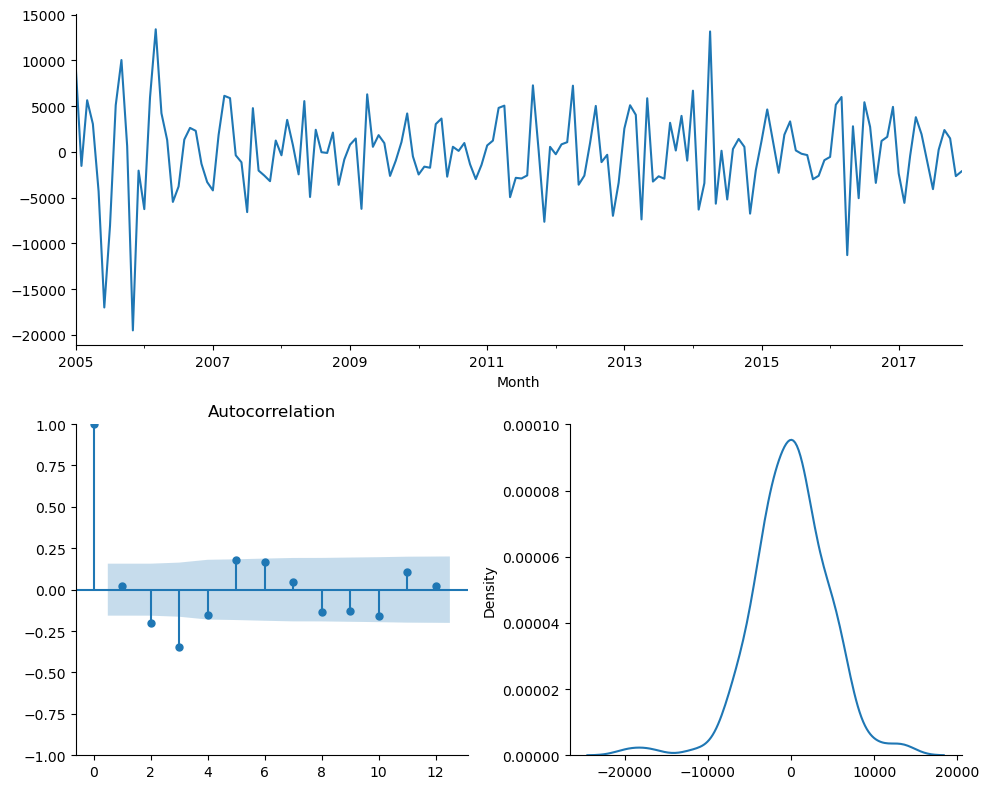

** Mean of the residuals:  -35.67

** Ljung Box Test, p-value: 0.068 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<Axes: xlabel='Month'>,
 <Axes: title={'center': 'Autocorrelation'}>,
 <Axes: ylabel='Density'>)

In [161]:
residcheck(arima_auto.resid(),12)

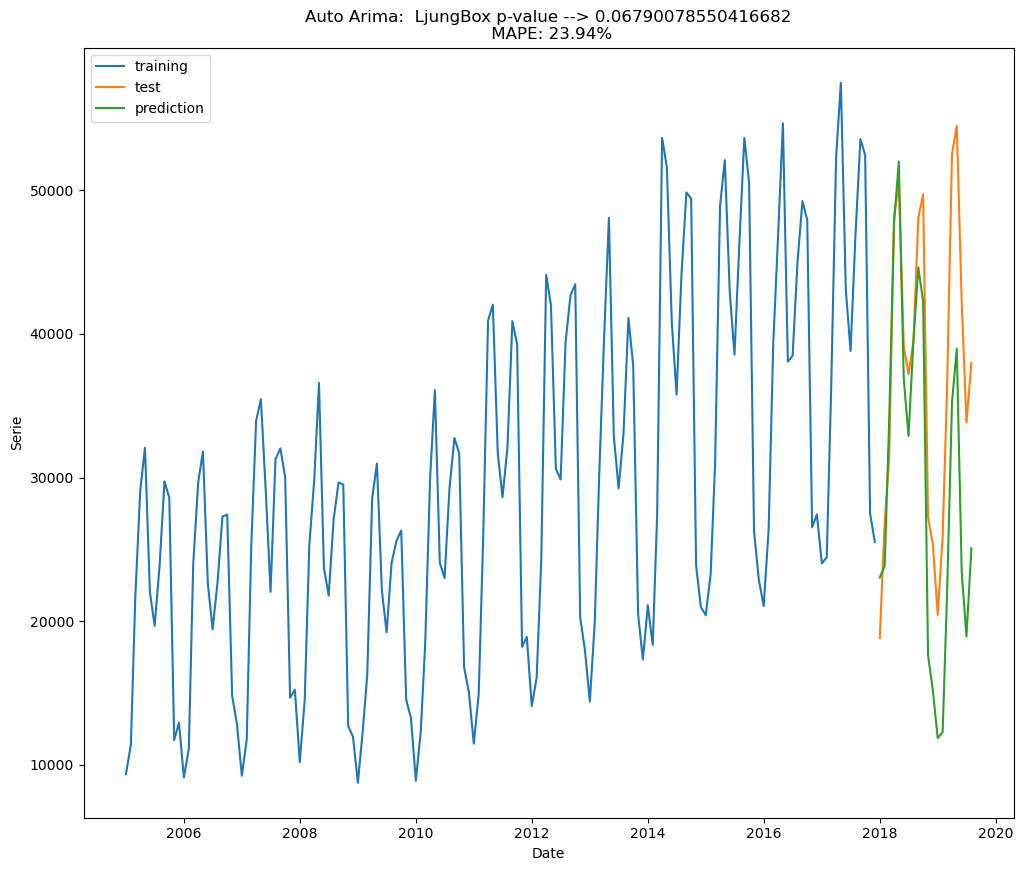

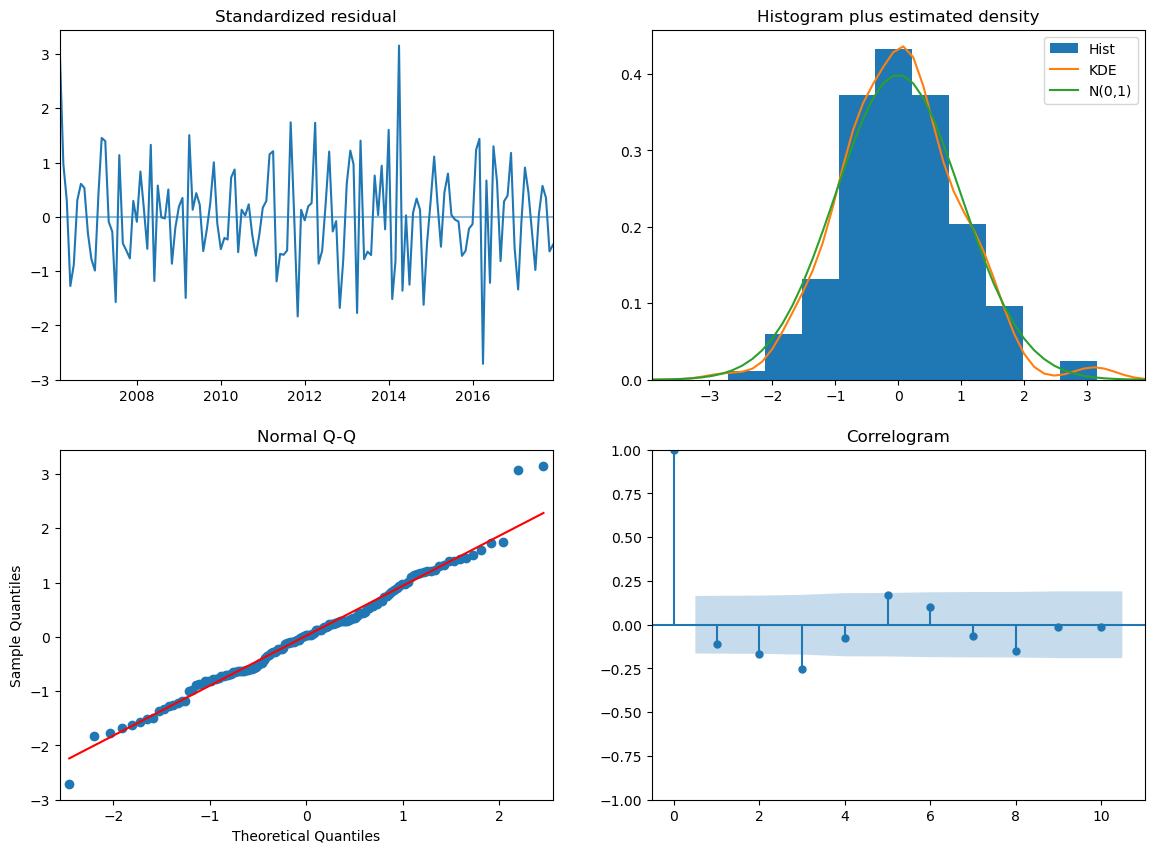

In [163]:
eval_model_Aarima(arima_auto,Cordoba_tr.V_Extranj,Cordoba_tst.V_Extranj,'Auto Arima')

2. **Residentes**

Vistazo a correlogramas.


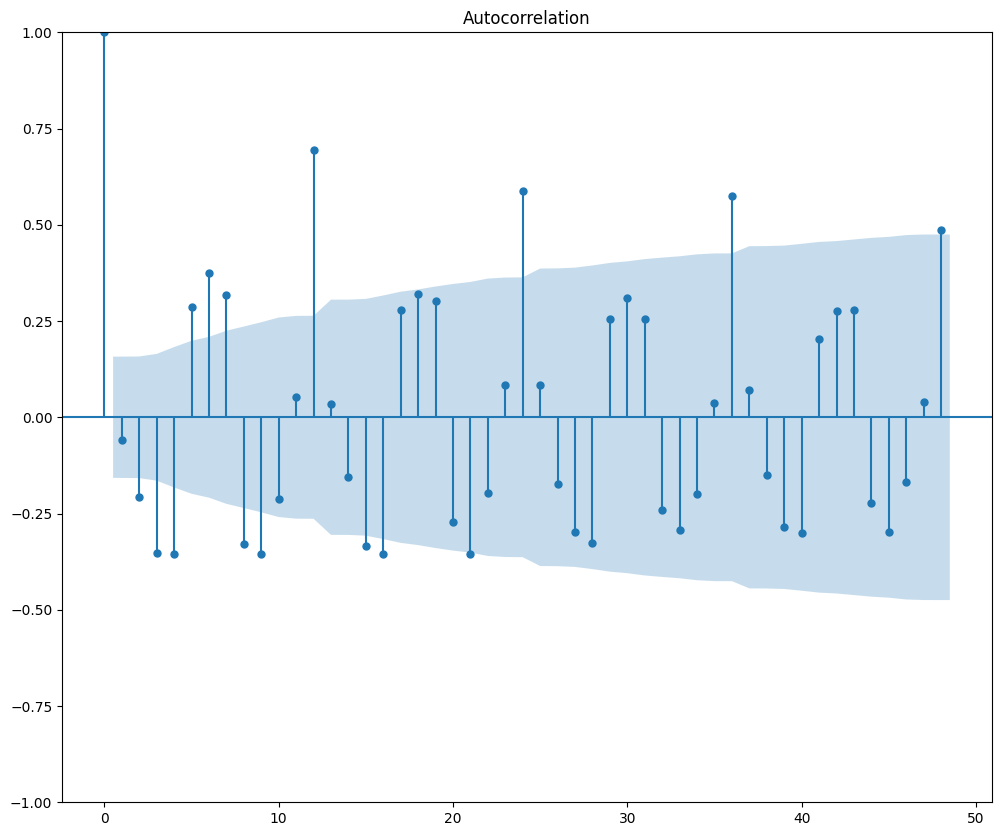

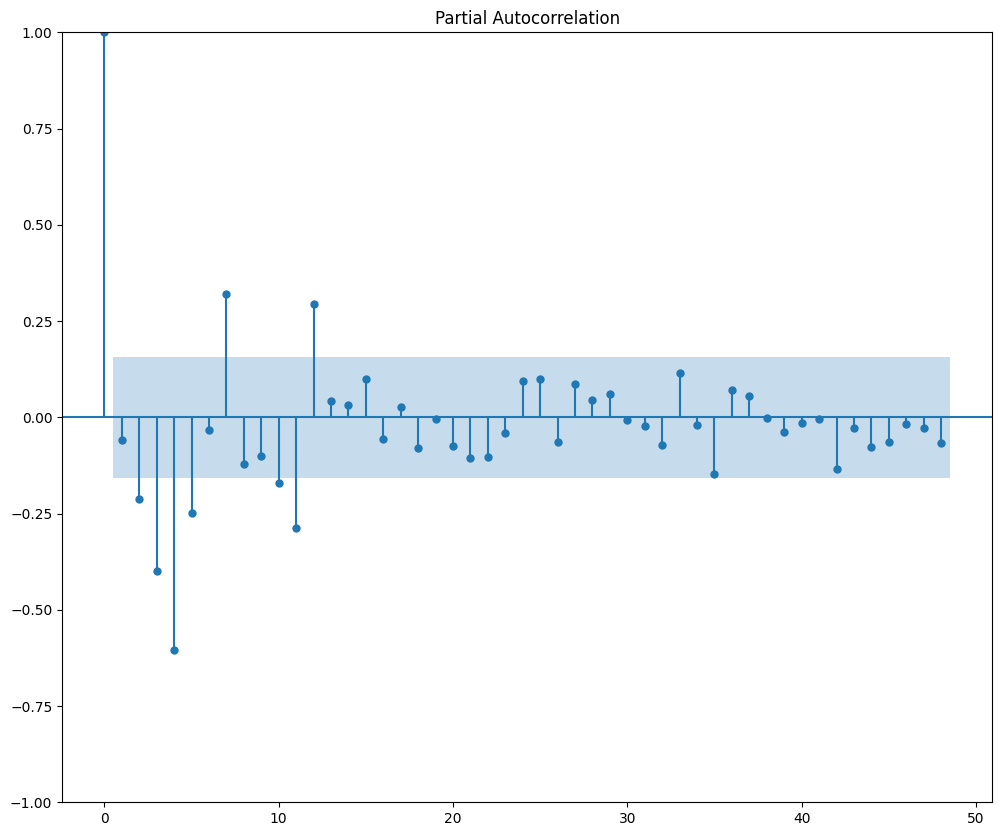

In [114]:
Resid_diff_1= Cordoba_tr.V_Resident.diff(periods=1)#.diff(periods=12)

plot_acf(Resid_diff_1.dropna(inplace=False),lags=48)
plt.show()
plot_pacf(Resid_diff_1.dropna(inplace=False),lags=48,method='ywm')
plt.show()


Parte AR de orden 2 enmascarada por parte MA de orden 1 en lo regular. 

Parte AR de orden 1-2 enmascarada por algo de MA seguramente en lo estacional

Por esto nuestros candidatos a ajustar serían: ARIMA(2,1,1)(1-2,1,0-1-2)[12], o cualquiera de sus variaciones en las porsiciones autoregresivas o de medias móviles.

**Arima Manual**


In [165]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
arima1 = SARIMAX(Cordoba_tr.V_Resident, 
                order = (2, 1, 1), 
                seasonal_order =(1, 1, 0, 12))
  
arima_1 = arima1.fit()
arima_1.summary()

C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          V_Resident   No. Observations:                  156
Model:             SARIMAX(2, 1, 1)x(1, 1, [], 12)   Log Likelihood               -1375.799
Date:                             Mon, 21 Apr 2025   AIC                           2761.598
Time:                                     20:10:03   BIC                           2776.412
Sample:                                 01-01-2005   HQIC                          2767.617
                                      - 12-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2956      0.474     -0.623      0.533      -1.225       0.634
ar.L2         -0.1721      0.165     -1.042      0.297      -0.496       0.152
ma.L1         -0.0796      0.465     -0.171      0.864      -0.991       0.831
ar.S.L12      -0.3116      0.032     -9.781      0.000      -0.374      -0.249
sigma2       1.17e+07   3.79e-08   3.09e+14      0.000    1.17e+07    1.17e+07
===================================================================================
Ljung-Box (L1) (Q):                   4.22   Jarque-Bera (JB):                 2.09
Prob(Q):                              0.04   Prob(JB):                         0.35
Heteroskedasticity (H):               0.52   Skew:                            -0.25
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.62e+30. Standard errors may be unstable.
"""

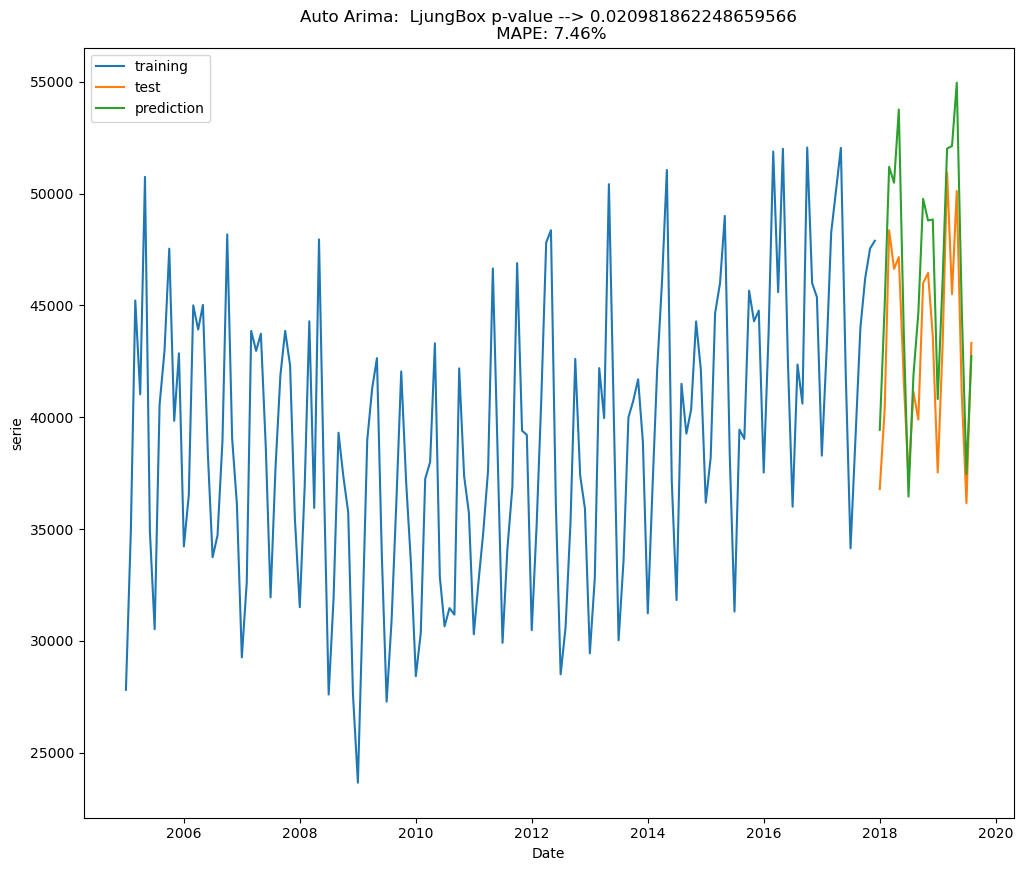

0.020981862248659566


In [167]:
eval_model(arima_1,Cordoba_tr.V_Resident,Cordoba_tst.V_Resident,'Auto Arima')

In [169]:
arima2 = SARIMAX(Cordoba_tr.V_Resident, 
                order = (0, 1, 1), 
                seasonal_order =(2, 1, 0, 12))
  
arima_2 = arima2.fit()
arima_2.summary()

C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          V_Resident   No. Observations:                  156
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood               -1367.472
Date:                             Mon, 21 Apr 2025   AIC                           2742.944
Time:                                     20:10:26   BIC                           2754.796
Sample:                                 01-01-2005   HQIC                          2747.760
                                      - 12-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3379      0.039     -8.682      0.000      -0.414      -0.262
ar.S.L12      -0.4427      0.044    -10.019      0.000      -0.529      -0.356
ar.S.L24      -0.2632      0.046     -5.740      0.000      -0.353      -0.173
sigma2      1.197e+07   4.61e-10    2.6e+16      0.000     1.2e+07     1.2e+07
===================================================================================
Ljung-Box (L1) (Q):                   3.13   Jarque-Bera (JB):                 1.28
Prob(Q):                              0.08   Prob(JB):                         0.53
Heteroskedasticity (H):               0.57   Skew:                            -0.22
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.43e+31. Standard errors may be unstable.
"""

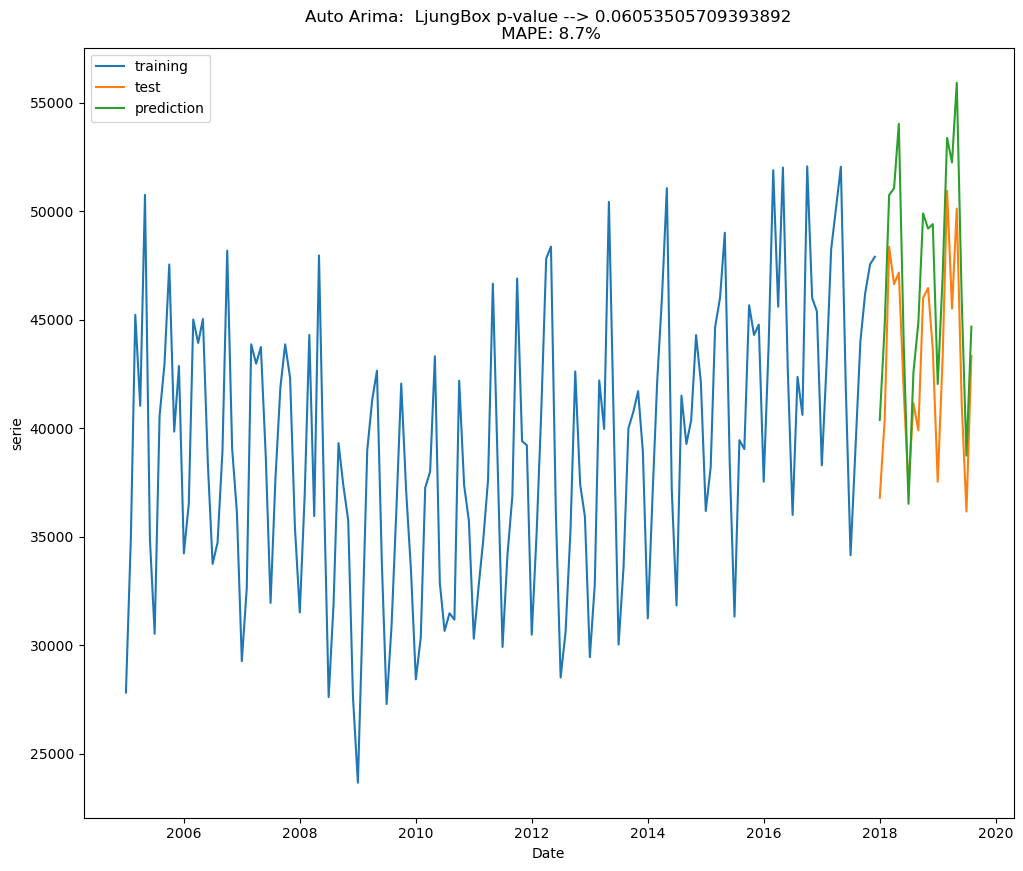

0.06053505709393892


In [171]:
eval_model(arima_2,Cordoba_tr.V_Resident,Cordoba_tst.V_Resident,'Auto Arima')

In [173]:
arima3 = SARIMAX(Cordoba_tr.V_Resident, 
                order = (1, 1, 1), 
                seasonal_order =(1, 0, 2 , 12))
  
arima_3 = arima3.fit()
arima_3.summary()

C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                              V_Resident   No. Observations:                  156
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood               -1509.918
Date:                                 Mon, 21 Apr 2025   AIC                           3031.835
Time:                                         20:10:47   BIC                           3050.096
Sample:                                     01-01-2005   HQIC                          3039.252
                                          - 12-01-2017                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4946      0.090      5.469      0.000       0.317       0.672
ma.L1         -0.8980      0.053    -16.927      0.000      -1.002      -0.794
ar.S.L12       0.9988      0.007    145.272      0.000       0.985       1.012
ma.S.L12      -0.9010      0.104     -8.685      0.000      -1.104      -0.698
ma.S.L24      -0.0579      0.079     -0.737      0.461      -0.212       0.096
sigma2      1.456e+07   6.31e-09   2.31e+15      0.000    1.46e+07    1.46e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                17.80
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                             0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.97e+30. Standard errors may be unstable.
"""

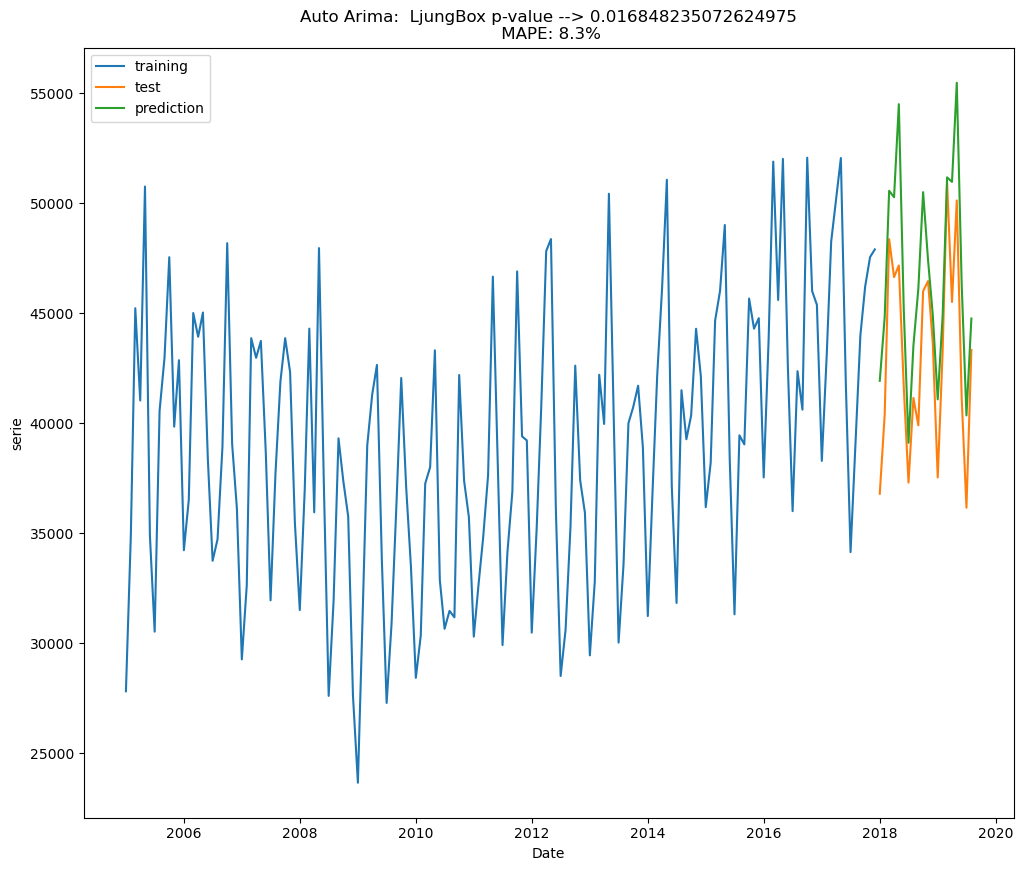

0.016848235072624975


In [175]:
eval_model(arima_3,Cordoba_tr.V_Resident,Cordoba_tst.V_Resident,'Auto Arima')

Auto ARIMA 

Vamos a aplicar automatismos para buscar los mejores órdenes en relación al AIC utilizando auro_arima.


In [177]:
Cordoba_tr.V_Resident.shape

(156,)

In [179]:
# Auto arima
arima_auto = pm.auto_arima(Cordoba_tr.V_Resident, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=12,              # frequency of series
                      d=2,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      #start_P=None, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(arima_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.64 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=3249.825, Time=0.07 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=3156.046, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=3220.179, Time=0.03 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=3122.183, Time=0.58 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=3099.823, Time=0.92 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(1,2,0)(2,0,2)[12]             : AIC=inf, Time=1.06 sec
 ARIMA(1,2,0)(1,0,2)[12]             : AIC=inf, Time=0.94 sec
 ARIMA(0,2,0)(2,0,1)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(2,2,0)(2,0,1)[12]             : AIC=inf, Time=1.70 sec
 ARIMA(1,2,1)(2,0,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(2,2,1)(2,0,1)[12]             : AIC=inf, Time=1.08 sec
 ARI

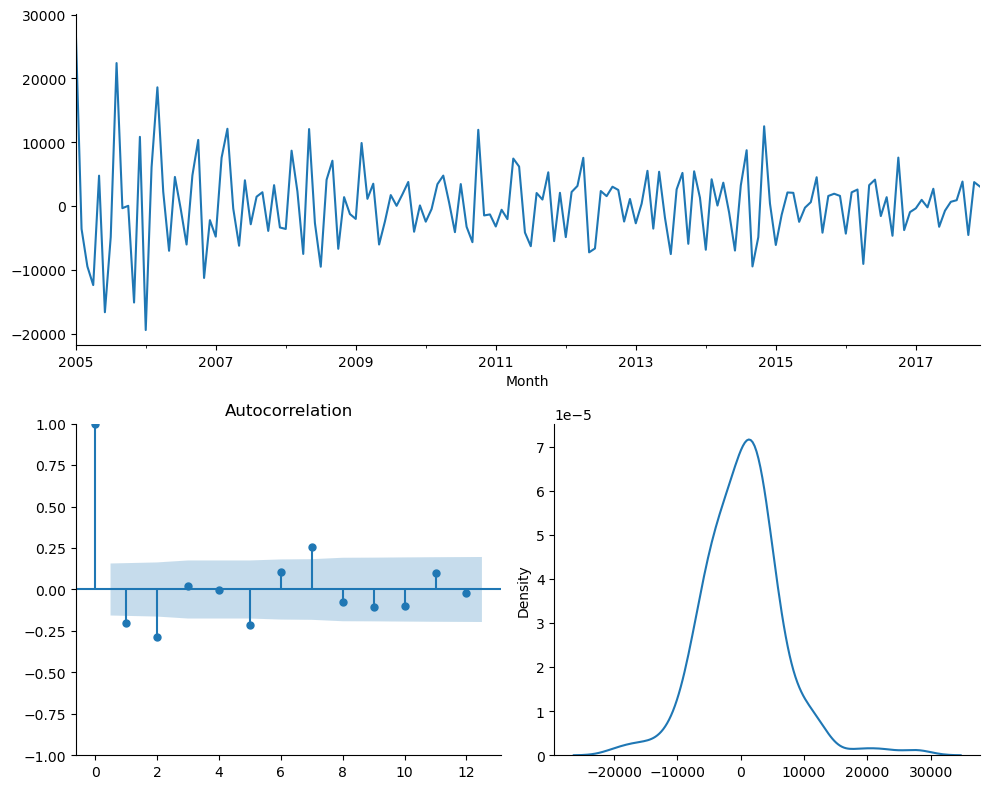

** Mean of the residuals:  298.84

** Ljung Box Test, p-value: 0.001 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<Axes: xlabel='Month'>,
 <Axes: title={'center': 'Autocorrelation'}>,
 <Axes: ylabel='Density'>)

In [181]:
residcheck(arima_auto.resid(),12)

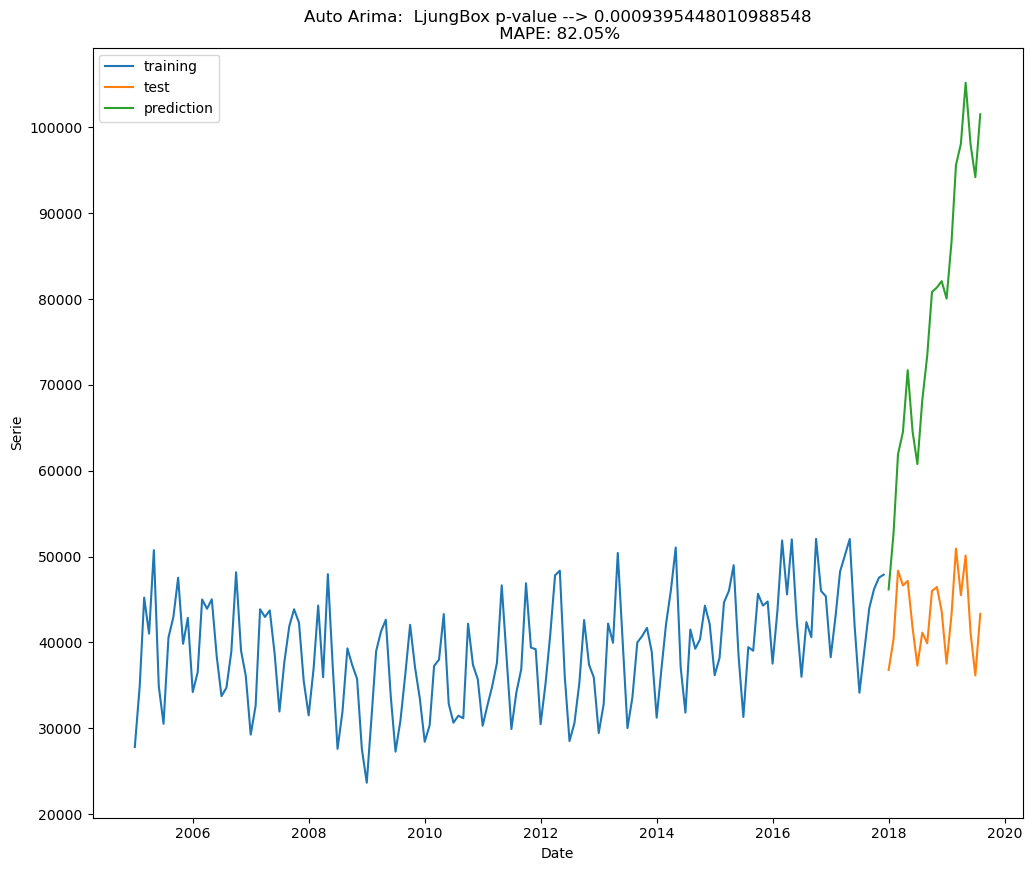

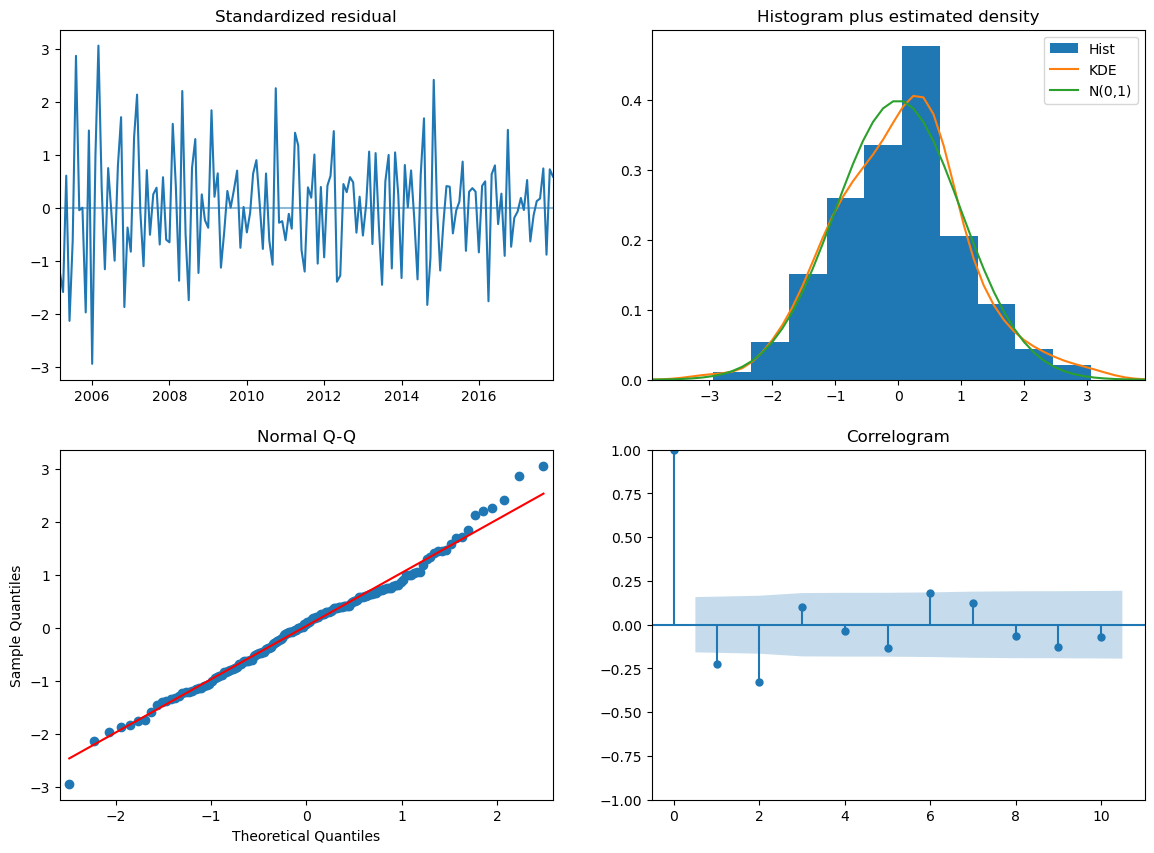

In [183]:
eval_model_Aarima(arima_auto,Cordoba_tr.V_Resident,Cordoba_tst.V_Resident,'Auto Arima')